In [1]:
#Imports
import os
import sqlite3
import pandas as pd
import hdf5_getters
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from os import path
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
#Additional Settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [3]:
#Load in all songs from Million Song Dataset
connection = sqlite3.connect('track_metadata.db')
df = pd.read_sql_query("SELECT * FROM songs", connection)
connection.close()

In [4]:
#View all cell output
# pd.set_option('display.max_colwidth', None)

#Reset width of columns
# pd.reset_option('display.max_colwidth')

Learn and visualize the structure of song data from the songs table in the track_metadata.db:

In [5]:
df.head()

track_id              title             song_id  \
0  TRMMMYQ128F932D901       Silent Night  SOQMMHC12AB0180CB8   
1  TRMMMKD128F425225D        Tanssi vaan  SOVFVAK12A8C1350D9   
2  TRMMMRX128F93187D9  No One Could Ever  SOGTUKN12AB017F4F1   
3  TRMMMCH128F425532C      Si Vos Querés  SOBNYVR12A8C13558C   
4  TRMMMWA128F426B589   Tangle Of Aspens  SOHSBXH12A8C13B0DF   

                                release           artist_id  \
0                 Monster Ballads X-Mas  ARYZTJS1187B98C555   
1                           Karkuteillä  ARMVN3U1187FB3A1EB   
2                                Butter  ARGEKB01187FB50750   
3                               De Culo  ARNWYLR1187B9B2F9C   
4  Rene Ablaze Presents Winter Sessions  AREQDTE1269FB37231   

                            artist_mbid       artist_name   duration  \
0  357ff05d-848a-44cf-b608-cb34b5701ae5  Faster Pussy cat  252.05506   
1  8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9  Karkkiautomaatti  156.55138   
2  3d403d44-36ce-465c-ad43-ae877e65adc4    Hudson Mohawke  138.97098   
3  12be7648-7094-495f-90e6-df4189d68615       Yerba Brava  145.05751   
4                                              Der Mystic  514.29832   

   artist_familiarity  artist_hotttnesss  year  track_7digitalid  shs_perf  \
0            0.649822           0.394032  2003           7032331        -1   
1            0.439604           0.356992  1995           1514808        -1   
2            0.643681           0.437504  2006           6945353        -1   
3            0.448501           0.372349  2003           2168257        -1   
4            0.000000           0.000000     0           2264873        -1   

   shs_work  
0         0  
1         0  
2         0  
3         0  
4         0

Create a DataFrame for each user that matches their Spotify Listening History, based off of the .h5 files located within /h5Files/user1_h5Files & /h5Files/user2_h5Files:

In [6]:
# #Read in list of .h5 file names from a text file.
user1_h5FileNames = os.listdir(os.path.join('.', 'h5Files', 'user1_h5Files'))
user2_h5FileNames = os.listdir(os.path.join('.', 'h5Files', 'user2_h5Files'))

#Remove the .h5 file extension from each file name.
user1_h5FileNames = [fileName.replace('.h5', '') for fileName in user1_h5FileNames]
user2_h5FileNames = [fileName.replace('.h5', '') for fileName in user2_h5FileNames]

#Filter allDataDF based on matching songs.
user1DF = df.loc[df['track_id'].isin(user1_h5FileNames)]
user2DF = df.loc[df['track_id'].isin(user2_h5FileNames)]

For each song in the user DataFrames, get all of the additional song attributes from their respective .h5 files:

In [7]:
def getAttribute(track_id, function, user):
    """ Get additional hdf5 song attributes
        given a track_id.

        Parameters:
        track_id (str): Unique identifier for a given song.
            Part of filename.
        function (func): hdf5 function to call.
        user (str): Used to specify 'Ben' vs. 'Katie'.

        Returns:
        value (dynamic): Returned value from function.
    """
    
    if user == 'user1':
        folder = 'user1_h5Files'
    else:
        folder = 'user2_h5Files'
    filePath = path.join('h5Files', folder, track_id + '.h5')
    h5 = hdf5_getters.open_h5_file_read(filePath)
    value = function(h5)

    h5.close()
    return value

In [8]:
def appendAdditionalAttributes(userDF, user):
    """ Get additional song features from an HDF5 song file (same name as `track_id`)
        and append them as additional columns for each song in userDF.

    Parameters:
    userDF (DataFrame): The user specific DataFrame to append additional features to.
    user (str): A string representing a specific user. Used to define file location of h5 files.

    Returns:
    userDF (DataFrame): Updated DataFrame with additional attributes.
    """

    attributeNames = ['num_songs', 'artist_playmeid', 'artist_7digitalid', 'artist_latitude',
    'artist_longitude', 'artist_location', 'similar_artists', 'artist_terms',
    'artist_terms_freq', 'artist_terms_weight', 'analysis_sample_rate', 'audio_md5',
    'danceability', 'end_of_fade_in', 'energy', 'key', 'key_confidence', 'loudness',
    'mode', 'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature',
    'time_signature_confidence', 'segments_start', 'segments_confidence', 'segments_pitches',
    'segments_timbre', 'segments_loudness_max', 'segments_loudness_max_time',
    'segments_loudness_start', 'sections_start', 'sections_confidence', 'beats_start',
    'beats_confidence', 'bars_start', 'bars_confidence', 'tatums_start', 'tatums_confidence',
    'artist_mbtags', 'artist_mbtags_count']

    for attribute in attributeNames:
        #Double check that the syntax of `attribute` (which is a variable) in the line below.
        userDF[attribute] = userDF['track_id'].apply(getAttribute, args = (getattr(hdf5_getters, 'get_' + attribute), user))

    return userDF

In [9]:
user1DF = appendAdditionalAttributes(user1DF, 'user1')

In [10]:
user2DF = appendAdditionalAttributes(user2DF, 'user2')

In [11]:
user1DF = user1DF.reset_index(drop = True)
user2DF = user2DF.reset_index(drop = True)

#Include reference column for each DataFrame before combining
user1DF['User'] = 'user1'
user2DF['User'] = 'user2'

combinedDF = pd.concat([user1DF, user2DF])
combinedDF = combinedDF.reset_index(drop = True)

Data analysis of the prior and appended additional attributes within the combined DataFrame to prepare for feature analysis:

In [12]:
combinedDF.head()

track_id                       title             song_id  \
0  TRMWNOO128F9309A56      Smile Like You Mean It  SOFHTIO12A6D4F6128   
1  TRMWXEG12903CDE1AD           Ink My Whole Body  SOKJBXF12A58A7CD00   
2  TRMHLAL128F92D5D3A                        Halo  SONQBQA12A8C141D2C   
3  TRMCPVR128F9309A62  Everything Will Be Alright  SOWEWCO12A8C14074E   
4  TRMCOYC128F92E895E                Electric Eye  SOWYRBP12A8C142826   

               release           artist_id  \
0             Hot Fuss  ARVG4OK1187B9B6BD3   
1    Ink My Whole Body  ARN0GFV1187FB508CC   
2                 Halo  AR65K7A1187FB4DAA4   
3             Hot Fuss  ARVG4OK1187B9B6BD3   
4  Metal Works '73-'93  ARC4L071187B9AC2C0   

                            artist_mbid   artist_name   duration  \
0  95e1ead9-4d31-4808-a7ac-32c3614c116b   The Killers  235.15383   
1  f5dfa020-ad69-41cd-b3d4-fd7af0414e94   Wiz Khalifa  155.40200   
2  183105b5-3e68-4748-9086-2c1c11bf7a3d       Beyoncé  349.90975   
3  95e1ead9-4d31-4808-a7ac-32c3614c116b   The Killers  344.78975   
4  6b335658-22c8-485d-93de-0bc29a1d0349  Judas Priest  223.29424   

   artist_familiarity  artist_hotttnesss  year  track_7digitalid  shs_perf  \
0            0.918452           0.819588  2003           4465245     47256   
1            0.773935           0.778657  2010           7568532        -1   
2            0.889461           0.619431  2008           4765936    119325   
3            0.918452           0.828906  2004           4465257        -1   
4            0.825853           0.577596  1982           5304395        -1   

   shs_work  num_songs  artist_playmeid  artist_7digitalid  artist_latitude  \
0     47256          1             1573                616              NaN   
1         0          1               -1              91678              NaN   
2    112700          1              193              21453              NaN   
3         0          1             1573                616              NaN   
4         0          1             2199              50420         52.47859   

   artist_longitude         artist_location  \
0               NaN                     b''   
1               NaN                     b''   
2               NaN                     b''   
3               NaN                     b''   
4           -1.9086  b'Birmingham, England'   

                                     similar_artists  \
0  [b'ARVN9FZ1187FB393F1', b'AR9O98A1187FB39621',...   
1  [b'ARNWZ1N1187B9B71BA', b'ARUHBIQ1187FB36344',...   
2  [b'ART4QZC1187FB51612', b'ARKSZW81187B9B695D',...   
3  [b'ARVN9FZ1187FB393F1', b'AR9O98A1187FB39621',...   
4  [b'ARHTAPO1187FB5AADE', b'ARUJFOC122988FBB47',...   

                                        artist_terms  \
0  [b'rock', b'alternative', b'rave', b'disco', b...   
1  [b'hip hop', b'rap', b'hardcore rap', b'east c...   
2  [b'hip hop', b'pop', b'rock', b'soul', b'adult...   
3  [b'rock', b'alternative', b'rave', b'disco', b...   
4  [b'heavy metal', b'rock', b'metal', b'england'...   

                                   artist_terms_freq  \
0  [1.0, 0.8476018315794605, 0.3707999554207882, ...   
1  [1.0, 0.9210169950675368, 0.5689538879015632, ...   
2  [0.9991547737064872, 1.0, 0.9991734363766684, ...   
3  [1.0, 0.8476018315794605, 0.3707999554207882, ...   
4  [1.0, 1.0, 0.8854767446593553, 0.6868037557371...   

                                 artist_terms_weight  analysis_sample_rate  \
0  [1.0, 0.8889613897444565, 0.6476217325902135, ...                 22050   
1  [1.0, 0.9275388927691497, 0.7808967422586152, ...                 22050   
2  [1.0, 0.934469637447439, 0.8994327999896555, 0...                 22050   
3  [1.0, 0.8889613897444565, 0.6476217325902135, ...                 22050   
4  [1.0, 0.8710280883340099, 0.8356279750111977, ...                 22050   

                             audio_md5  danceability  end_of_fade_in  energy  \
0  b'e0a6385f0cf30208d36fd79db25c72cf'           0.0           4.348     0.0   
1  b'6cdc3f167c9c9d53

In [13]:
#Describe the data
combinedDF.describe()

duration  artist_familiarity  artist_hotttnesss         year  \
count  765.000000          765.000000         765.000000   765.000000   
mean   241.545125            0.794717           0.621505  1839.456209   
std     73.654010            0.107636           0.146042   541.950279   
min      0.574240            0.030769           0.276945     0.000000   
25%    197.824850            0.744410           0.529125  1989.000000   
50%    227.604440            0.823548           0.592615  2003.000000   
75%    268.329340            0.865022           0.693108  2007.000000   
max    703.085260            1.000000           1.082503  2010.000000   

       track_7digitalid       shs_perf       shs_work  num_songs  \
count      7.650000e+02     765.000000     765.000000      765.0   
mean       3.823740e+06    7037.881046    6725.613072        1.0   
std        2.501238e+06   22245.982414   20907.401803        0.0   
min        4.210000e+02      -1.000000    -915.000000        1.0   
25%        1.954574e+06      -1.000000       0.000000        1.0   
50%        3.516930e+06      -1.000000       0.000000        1.0   
75%        5.807333e+06      -1.000000       0.000000        1.0   
max        9.049534e+06  141175.000000  115786.000000        1.0   

       artist_playmeid  artist_7digitalid  artist_latitude  artist_longitude  \
count       765.000000         765.000000       266.000000        266.000000   
mean      15224.690196       61285.050980        39.975308        -65.978571   
std       40842.165530      105376.517273        10.201535         43.784600   
min          -1.000000          -1.000000        13.111990       -123.114030   
25%         144.000000        1447.000000        34.053490        -90.077710   
50%        1201.000000       11314.000000        40.879175        -77.381900   
75%        7529.000000       52035.000000        44.345155        -59.598950   
max      212208.000000      578298.000000        62.198450         51.408830   

       analysis_sample_rate  danceability  end_of_fade_in  energy         key  \
count                 765.0         765.0      765.000000   765.0  765.000000   
mean                22050.0           0.0        0.789374     0.0    5.377778   
std                     0.0           0.0        1.778127     0.0    3.575627   
min                 22050.0           0.0        0.000000     0.0    0.000000   
25%                 22050.0           0.0        0.000000     0.0    2.000000   
50%                 22050.0           0.0        0.195000     0.0    5.000000   
75%                 22050.0           0.0        0.440000     0.0    9.000000   
max                 22050.0           0.0       15.482000     0.0   11.000000   

       key_confidence    loudness        mode  mode_confidence  \
count      765.000000  765.000000  765.000000       765.000000   
mean         0.449369   -6.886408    0.664052         0.486163   
std          0.262878    3.502302    0.472630         0.185872   
min          0.000000  -27.076000    0.000000         0.000000   
25%          0.255000   -8.048000    0.000000         0.381000   
50%          0.470000   -6.070000    1.000000         0.495000   
75%          0.632000   -4.473000    1.000000         0.609000   
max          1.000000   -0.726000    1.000000         1.000000   

       start_of_fade_out       tempo  time_signature  \
count         765.000000  765.000000      765.000000   
mean          233.559081  125.744722        3.824837   
std            73.266189   30.925556        0.949323   
min             0.574000    0.000000        1.000000   
25%           190.694000  102.479000        4.000000   
50%           219.179000  125.022000        4.000000   
75%           258.171000  144.993000        4.000000   
max           697.028000  240.252000        7.000000   

       time_signature_confidence  
count                 765.000000  
mean                    0.578518  
std                     0.361406  
min                     0.000000  
25%         

In [14]:
#Get the DataTypes for each column:
combinedDF.dtypes

track_id                       object
title                          object
song_id                        object
release                        object
artist_id                      object
artist_mbid                    object
artist_name                    object
duration                      float64
artist_familiarity            float64
artist_hotttnesss             float64
year                            int64
track_7digitalid                int64
shs_perf                        int64
shs_work                        int64
num_songs                       int64
artist_playmeid                 int32
artist_7digitalid               int32
artist_latitude               float64
artist_longitude              float64
artist_location                object
similar_artists                object
artist_terms                   object
artist_terms_freq              object
artist_terms_weight            object
analysis_sample_rate            int32
audio_md5                      object
danceability

In [15]:
#Count instances of cells that are 0, NaN, Null or an empty String
print("len(combinedDF): ", len(combinedDF), "\n")
for column in combinedDF.columns:
    try:
        num_of_0 = (combinedDF[column] == 0).sum()
    except:
        num_of_0 = 'This is an array'
    num_of_null_NaN = (combinedDF[column].isna()).sum()
    num_of_empty_string = (combinedDF[column] == '').sum()

    print(column + ":", "\nInstances of 0:\t\t\t", num_of_0, "\nInstances of null/NaN\t\t", num_of_null_NaN, "\nInstances of empty string:\t", num_of_empty_string, "\n")

len(combinedDF):  765 

track_id: 
Instances of 0:			 0 
Instances of null/NaN		 0 
Instances of empty string:	 0 

title: 
Instances of 0:			 0 
Instances of null/NaN		 0 
Instances of empty string:	 0 

song_id: 
Instances of 0:			 0 
Instances of null/NaN		 0 
Instances of empty string:	 0 

release: 
Instances of 0:			 0 
Instances of null/NaN		 0 
Instances of empty string:	 0 

artist_id: 
Instances of 0:			 0 
Instances of null/NaN		 0 
Instances of empty string:	 0 

artist_mbid: 
Instances of 0:			 0 
Instances of null/NaN		 0 
Instances of empty string:	 11 

artist_name: 
Instances of 0:			 0 
Instances of null/NaN		 0 
Instances of empty string:	 0 

duration: 
Instances of 0:			 0 
Instances of null/NaN		 0 
Instances of empty string:	 0 

artist_familiarity: 
Instances of 0:			 0 
Instances of null/NaN		 0 
Instances of empty string:	 0 

artist_hotttnesss: 
Instances of 0:			 0 
Instances of null/NaN		 0 
Instances of empty string:	 0 

year: 
Instances of 0:			 61 
Inst

In [16]:
combinedDF.head()

track_id                       title             song_id  \
0  TRMWNOO128F9309A56      Smile Like You Mean It  SOFHTIO12A6D4F6128   
1  TRMWXEG12903CDE1AD           Ink My Whole Body  SOKJBXF12A58A7CD00   
2  TRMHLAL128F92D5D3A                        Halo  SONQBQA12A8C141D2C   
3  TRMCPVR128F9309A62  Everything Will Be Alright  SOWEWCO12A8C14074E   
4  TRMCOYC128F92E895E                Electric Eye  SOWYRBP12A8C142826   

               release           artist_id  \
0             Hot Fuss  ARVG4OK1187B9B6BD3   
1    Ink My Whole Body  ARN0GFV1187FB508CC   
2                 Halo  AR65K7A1187FB4DAA4   
3             Hot Fuss  ARVG4OK1187B9B6BD3   
4  Metal Works '73-'93  ARC4L071187B9AC2C0   

                            artist_mbid   artist_name   duration  \
0  95e1ead9-4d31-4808-a7ac-32c3614c116b   The Killers  235.15383   
1  f5dfa020-ad69-41cd-b3d4-fd7af0414e94   Wiz Khalifa  155.40200   
2  183105b5-3e68-4748-9086-2c1c11bf7a3d       Beyoncé  349.90975   
3  95e1ead9-4d31-4808-a7ac-32c3614c116b   The Killers  344.78975   
4  6b335658-22c8-485d-93de-0bc29a1d0349  Judas Priest  223.29424   

   artist_familiarity  artist_hotttnesss  year  track_7digitalid  shs_perf  \
0            0.918452           0.819588  2003           4465245     47256   
1            0.773935           0.778657  2010           7568532        -1   
2            0.889461           0.619431  2008           4765936    119325   
3            0.918452           0.828906  2004           4465257        -1   
4            0.825853           0.577596  1982           5304395        -1   

   shs_work  num_songs  artist_playmeid  artist_7digitalid  artist_latitude  \
0     47256          1             1573                616              NaN   
1         0          1               -1              91678              NaN   
2    112700          1              193              21453              NaN   
3         0          1             1573                616              NaN   
4         0          1             2199              50420         52.47859   

   artist_longitude         artist_location  \
0               NaN                     b''   
1               NaN                     b''   
2               NaN                     b''   
3               NaN                     b''   
4           -1.9086  b'Birmingham, England'   

                                     similar_artists  \
0  [b'ARVN9FZ1187FB393F1', b'AR9O98A1187FB39621',...   
1  [b'ARNWZ1N1187B9B71BA', b'ARUHBIQ1187FB36344',...   
2  [b'ART4QZC1187FB51612', b'ARKSZW81187B9B695D',...   
3  [b'ARVN9FZ1187FB393F1', b'AR9O98A1187FB39621',...   
4  [b'ARHTAPO1187FB5AADE', b'ARUJFOC122988FBB47',...   

                                        artist_terms  \
0  [b'rock', b'alternative', b'rave', b'disco', b...   
1  [b'hip hop', b'rap', b'hardcore rap', b'east c...   
2  [b'hip hop', b'pop', b'rock', b'soul', b'adult...   
3  [b'rock', b'alternative', b'rave', b'disco', b...   
4  [b'heavy metal', b'rock', b'metal', b'england'...   

                                   artist_terms_freq  \
0  [1.0, 0.8476018315794605, 0.3707999554207882, ...   
1  [1.0, 0.9210169950675368, 0.5689538879015632, ...   
2  [0.9991547737064872, 1.0, 0.9991734363766684, ...   
3  [1.0, 0.8476018315794605, 0.3707999554207882, ...   
4  [1.0, 1.0, 0.8854767446593553, 0.6868037557371...   

                                 artist_terms_weight  analysis_sample_rate  \
0  [1.0, 0.8889613897444565, 0.6476217325902135, ...                 22050   
1  [1.0, 0.9275388927691497, 0.7808967422586152, ...                 22050   
2  [1.0, 0.934469637447439, 0.8994327999896555, 0...                 22050   
3  [1.0, 0.8889613897444565, 0.6476217325902135, ...                 22050   
4  [1.0, 0.8710280883340099, 0.8356279750111977, ...                 22050   

                             audio_md5  danceability  end_of_fade_in  energy  \
0  b'e0a6385f0cf30208d36fd79db25c72cf'           0.0           4.348     0.0   
1  b'6cdc3f167c9c9d53

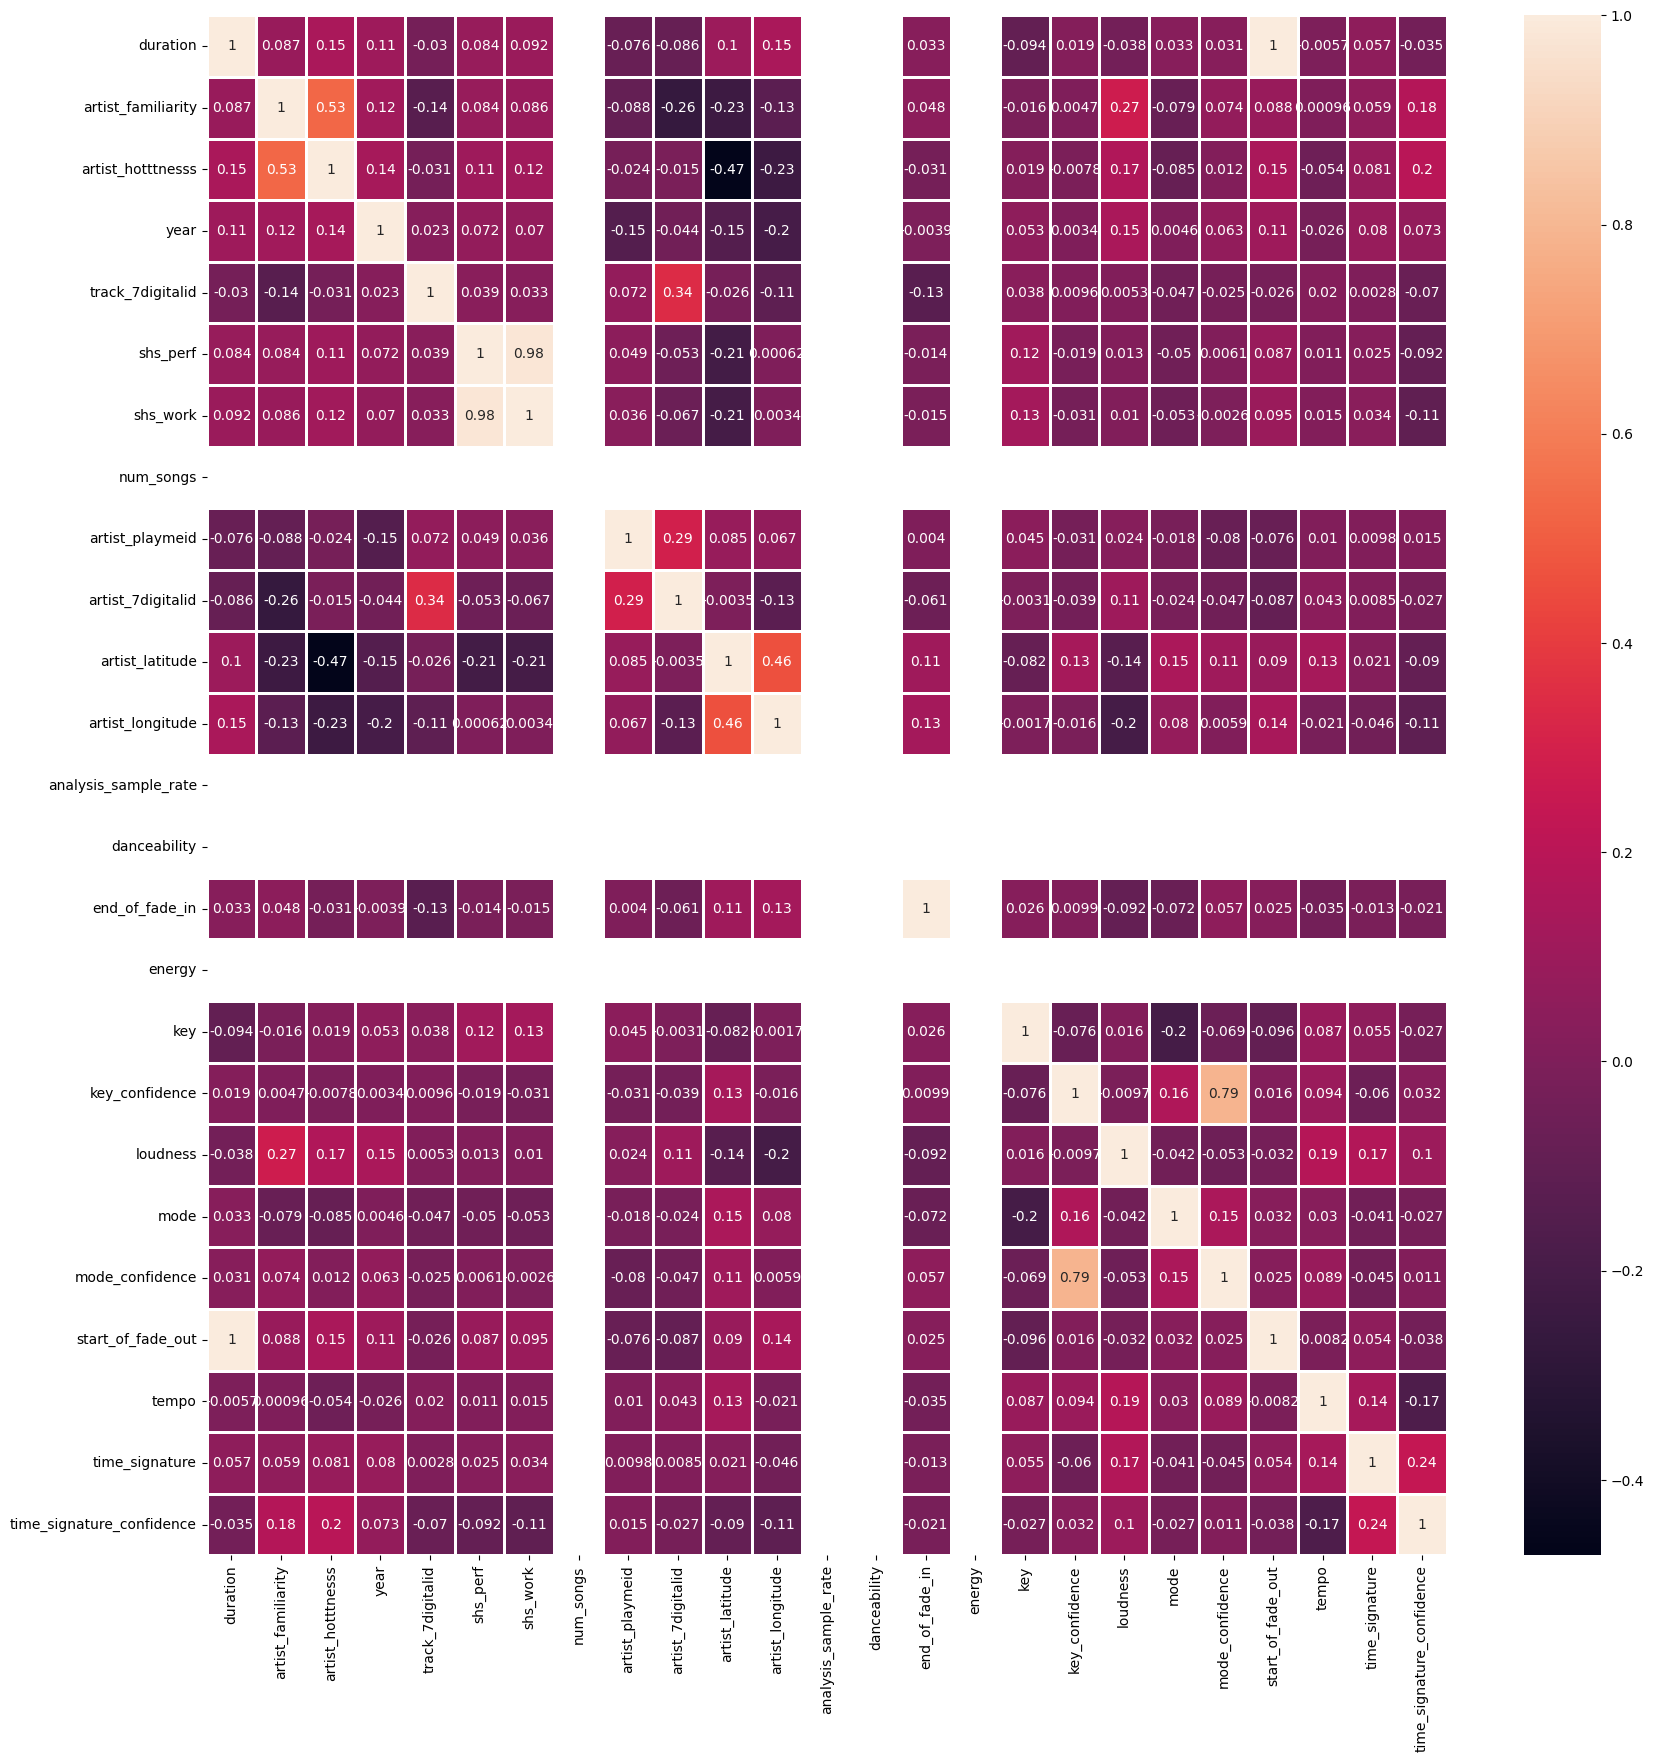

In [17]:
#Look at correlation matrix to view correlations between attributes:
correlation_matrix = combinedDF.corr()

fig, ax = plt.subplots(figsize=(20, 20))
# ax.set_ylim()

myheatmap = sn.heatmap(correlation_matrix, annot = True, linewidths=.75, ax=ax)

plt.show()

In [18]:
uselessAttributes = [ 'num_songs', #Always 1
'shs_perf', #Unknown attribute, 637 instances of -1
'shs_work', #Unknown attribute, 616 instances of 0
'artist_latitude', #499 instances of NaN
'artist_longitude', #499 instances of NaN
'artist_location', #Redundant if including latitude and longitude
'similar_artists', #Mapping would be too complex. List of artist IDs.

'artist_terms', #Contains genres. Could be added back as categorical attribute.
'artist_terms_freq', #Frequencies for artist_terms. These should be used together.
'artist_terms_weight', #Weights for artist_terms. These should be used together.

'analysis_sample_rate', #Always has value of 22050
'audio_md5', #Checksum value that we do not need for modeling.
'danceability', #Always 0
'energy', #Always 0
'key_confidence', #Confidence score for the musical key a song is set in. Not useful because we don't have confidence scores for other possible keys.
'mode_confidence', #This could be more useful than key_confidence, because mode is binary (0 or 1), and we know the confidence of the inverse. Might add this back.
'time_signature_confidence', #Confidence score for time signature of a song. No reference to other confidence score for other possible time signatures.

#All of these could be useful, but not sure yet how to handle arrays for model.ipynb
'segments_start', 'segments_confidence', 'segments_pitches', 'segments_timbre',	'segments_loudness_max', 'segments_loudness_max_time', 'segments_loudness_start', 'sections_start', 'sections_confidence', 'beats_start', 'beats_confidence', 'bars_start', 'bars_confidence', 'tatums_start', 'tatums_confidence',

'artist_mbtags', #More labels, stands for 'musicbrainz tags'. Hard to deal with.
'artist_mbtags_count' #Unique counts for artist_mbtags.
]

idColumns = ['track_id', 'song_id', 'artist_id', 'artist_mbid', 'track_7digitalid', 'artist_playmeid', 'artist_7digitalid']

In [19]:
combinedDFNoID = combinedDF.drop(columns = idColumns)
combinedDFFiltered = combinedDFNoID.drop(columns = uselessAttributes)

In [20]:
combinedDFFiltered.head()

title              release   artist_name   duration  \
0      Smile Like You Mean It             Hot Fuss   The Killers  235.15383   
1           Ink My Whole Body    Ink My Whole Body   Wiz Khalifa  155.40200   
2                        Halo                 Halo       Beyoncé  349.90975   
3  Everything Will Be Alright             Hot Fuss   The Killers  344.78975   
4                Electric Eye  Metal Works '73-'93  Judas Priest  223.29424   

   artist_familiarity  artist_hotttnesss  year  end_of_fade_in  key  loudness  \
0            0.918452           0.819588  2003           4.348    3    -3.746   
1            0.773935           0.778657  2010           0.779   11    -8.644   
2            0.889461           0.619431  2008           0.189   11    -7.111   
3            0.918452           0.828906  2004           4.632    0    -4.554   
4            0.825853           0.577596  1982           0.000    9   -11.318   

   mode  start_of_fade_out    tempo  time_signature   User  
0     0            227.103  125.274               4  user1  
1     0            149.182   90.076               4  user1  
2     0            339.185  129.972               4  user1  
3     0            333.015  128.241               4  user1  
4     1            220.079   96.971               4  user1

In [21]:
#Get number of unique values for each column
print([(column, combinedDFFiltered[column].nunique()) for column in combinedDFFiltered.columns]) #List of tuples

[('title', 681), ('release', 540), ('artist_name', 371), ('duration', 652), ('artist_familiarity', 409), ('artist_hotttnesss', 427), ('year', 54), ('end_of_fade_in', 291), ('key', 12), ('loudness', 662), ('mode', 2), ('start_of_fade_out', 684), ('tempo', 683), ('time_signature', 5), ('User', 2)]


Clean the data by imputing missing values as 'mean' and scale the data to prepare for training:

In [22]:
combinedDFScaled = combinedDFFiltered
combinedDFScaled['end_of_fade_in'] = combinedDFScaled['end_of_fade_in'] / combinedDFScaled['duration']
combinedDFScaled['start_of_fade_out'] = combinedDFScaled['start_of_fade_out'] / combinedDFScaled['duration']

combinedDFScaled['year'].replace(0, np.nan, inplace = True)
meanImputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
combinedDFScaled['year'] = meanImputer.fit_transform(combinedDFScaled[['year']])
combinedDFScaled['year'] = combinedDFScaled['year'].round().astype(int)

minMaxScaler = MinMaxScaler()
combinedDFScaled['duration'] = minMaxScaler.fit_transform(combinedDFScaled[['duration']])

combinedDFScaled['loudness'] = minMaxScaler.fit_transform(combinedDFScaled[['loudness']])

combinedDFScaled['tempo'] = minMaxScaler.fit_transform(combinedDFScaled[['tempo']])

combinedDFScaled['time_signature'] = minMaxScaler.fit_transform(combinedDFScaled[['time_signature']])

combinedDFScaled['year'] = minMaxScaler.fit_transform(combinedDFScaled[['year']])

combinedDFScaled['key'] = minMaxScaler.fit_transform(combinedDFScaled[['key']])

In [23]:
#Initialize DataFrame X to train the model on
X = combinedDFScaled.drop(columns = ['title', 'release', 'artist_name', 'User'])

In [24]:
X.head(n = 10)

duration  artist_familiarity  artist_hotttnesss      year  end_of_fade_in  \
0  0.333916            0.918452           0.819588  0.913580        0.018490   
1  0.220392            0.773935           0.778657  1.000000        0.005013   
2  0.497267            0.889461           0.619431  0.975309        0.000540   
3  0.489979            0.918452           0.828906  0.925926        0.013434   
4  0.317034            0.825853           0.577596  0.654321        0.000000   
5  0.762094            0.764882           0.614346  1.000000        0.000000   
6  0.257130            0.596468           0.453042  0.790123        0.000000   
7  0.452571            0.769944           0.536174  0.975309        0.000666   
8  0.428662            0.865022           0.916053  0.901235        0.002204   
9  0.272004            0.764348           0.610395  0.962963        0.000350   

        key  loudness  mode  start_of_fade_out     tempo  time_signature  
0  0.272727  0.885389     0           0.965764  0.521428             0.5  
1  1.000000  0.699507     0           0.959975  0.374923             0.5  
2  1.000000  0.757685     0           0.969350  0.540982             0.5  
3  0.000000  0.854725     0           0.965849  0.533777             0.5  
4  0.818182  0.598027     1           0.985601  0.403622             0.5  
5  0.090909  0.677002     1           0.933200  0.407901             0.5  
6  1.000000  0.335218     0           0.914713  0.464887             0.5  
7  0.545455  0.907894     1           0.974074  0.524341             0.5  
8  0.454545  0.534649     1           0.984572  0.306079             0.5  
9  0.181818  0.859317     1           0.945680  0.504812             0.5

Determine the optimal model parameters to train on by measuring BIC and silhouette scores:

In [25]:
n_components = [2, 3, 4, 5, 6, 7, 8, 9, 10]
covariance_type = ['full', 'tied', 'diag', 'spherical']
tol = [0.01, 0.001, 0.0001]
#Try changing n_init to a different value other than 1
init_params = ['kmeans', 'k-means++', 'random', 'random_from_data']

bestSilhouetteScore = -1
bestParams = {
    'n_components': -1,
    'covariance_type': 'null',
    'tol': -1,
    'init_params': 'null' 
}

for n in n_components:
    for ct in covariance_type:
        for t in tol:
            for ip in init_params:
                gmModel2 = GaussianMixture(n_components = n, covariance_type = ct, tol = t, init_params = ip, random_state = 42)
                gmModel2.fit(X)
                print('n_components = ', n, ' covariance_type = ', ct, ' tol = ', t, ' init_params = ', ip, ':')
                print('Number of iterations: ', gmModel2.n_iter_)
                print('Model weights: ', gmModel2.weights_)
                print('BIC: ', gmModel2.bic(X))
                print('AIC: ', gmModel2.aic(X))

                silhouetteScore = silhouette_score(X, gmModel2.predict(X))
                if silhouetteScore > bestSilhouetteScore:
                    bestSilhouetteScore = silhouetteScore
                    bestParams['n_components'] = n
                    bestParams['covariance_type'] = ct
                    bestParams['tol'] = t
                    bestParams['init_params'] = ip

                print('Silhouette score: ', silhouetteScore)
                print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')

print('Best model parameters: ', bestParams)
print('Best silhouette score: ', bestSilhouetteScore)

n_components =  2  covariance_type =  full  tol =  0.01  init_params =  kmeans :
Number of iterations:  2
Model weights:  [0.66405229 0.33594771]
BIC:  -23069.986036056194
AIC:  -23789.166790299307
Silhouette score:  0.4796992963951349
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
n_components =  2  covariance_type =  full  tol =  0.01  init_params =  k-means++ :
Number of iterations:  3
Model weights:  [0.66405229 0.33594771]
BIC:  -23069.986036056194
AIC:  -23789.166790299307
Silhouette score:  0.4796992963951349
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
n_components =  2  covariance_type =  full  tol =  0.01  init_params =  random :
Number of iterations:  13
Model weights:  [0.31787317 0.68212683]
BIC:  -16240.618645358187
AIC:  -16959.7993996013
Silhouette score:  0.05974434505445271
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
n_components =  2  covariance_type =  full  tol =  0.01  init_params =  random_from_data :
Number of iterations:  3
Model weights:  [0.66405229 0.33594771]
BIC:  -23069.

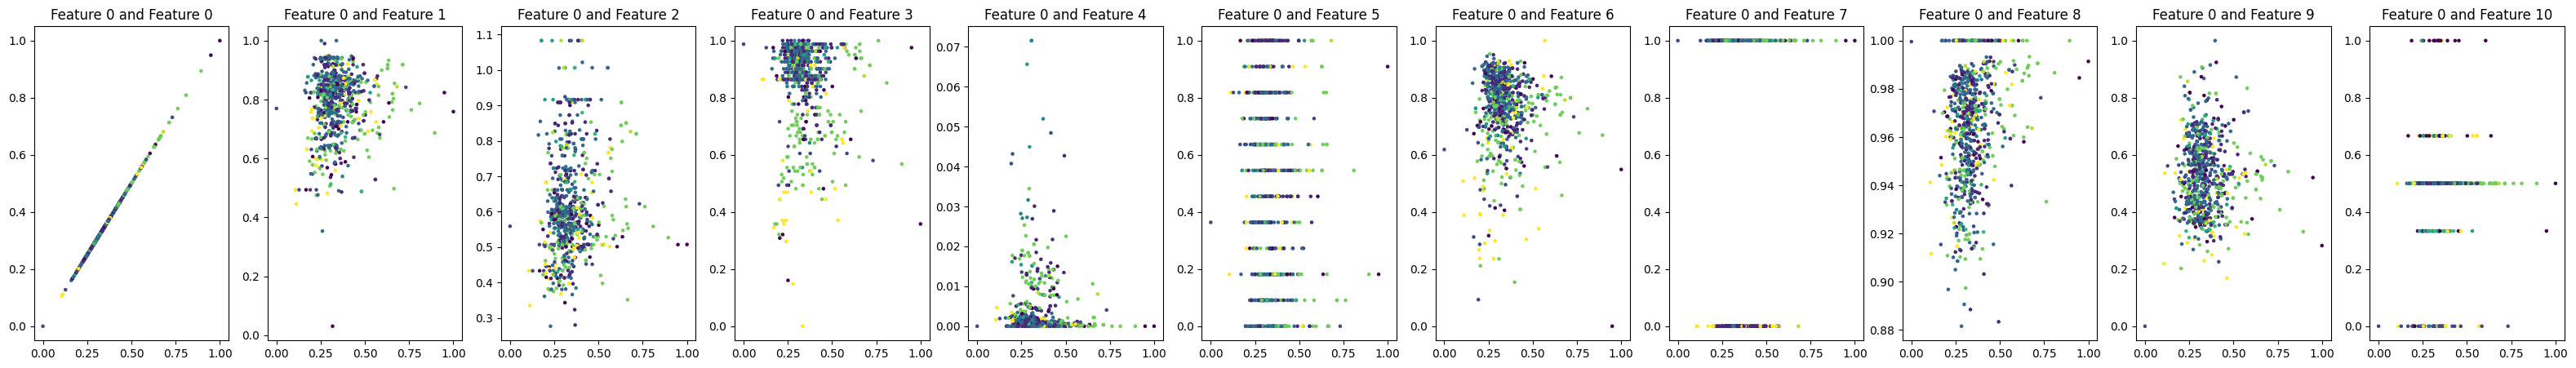

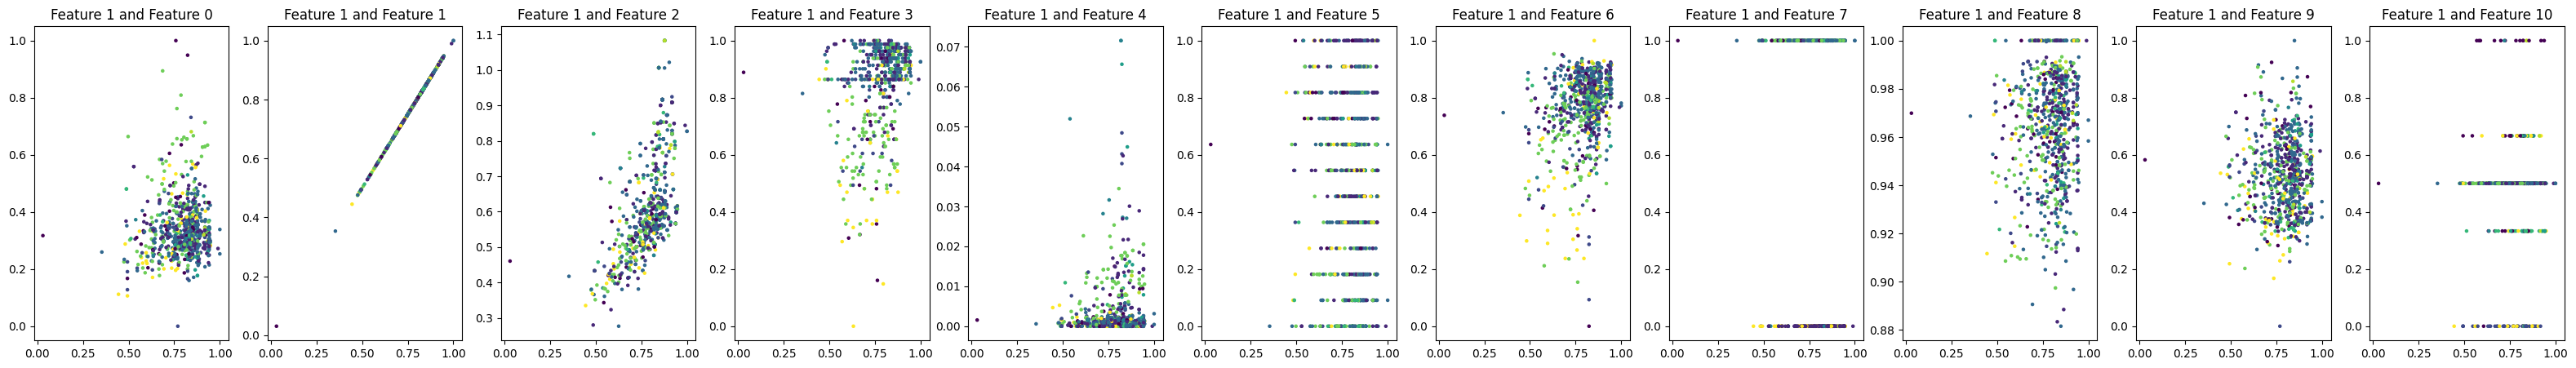

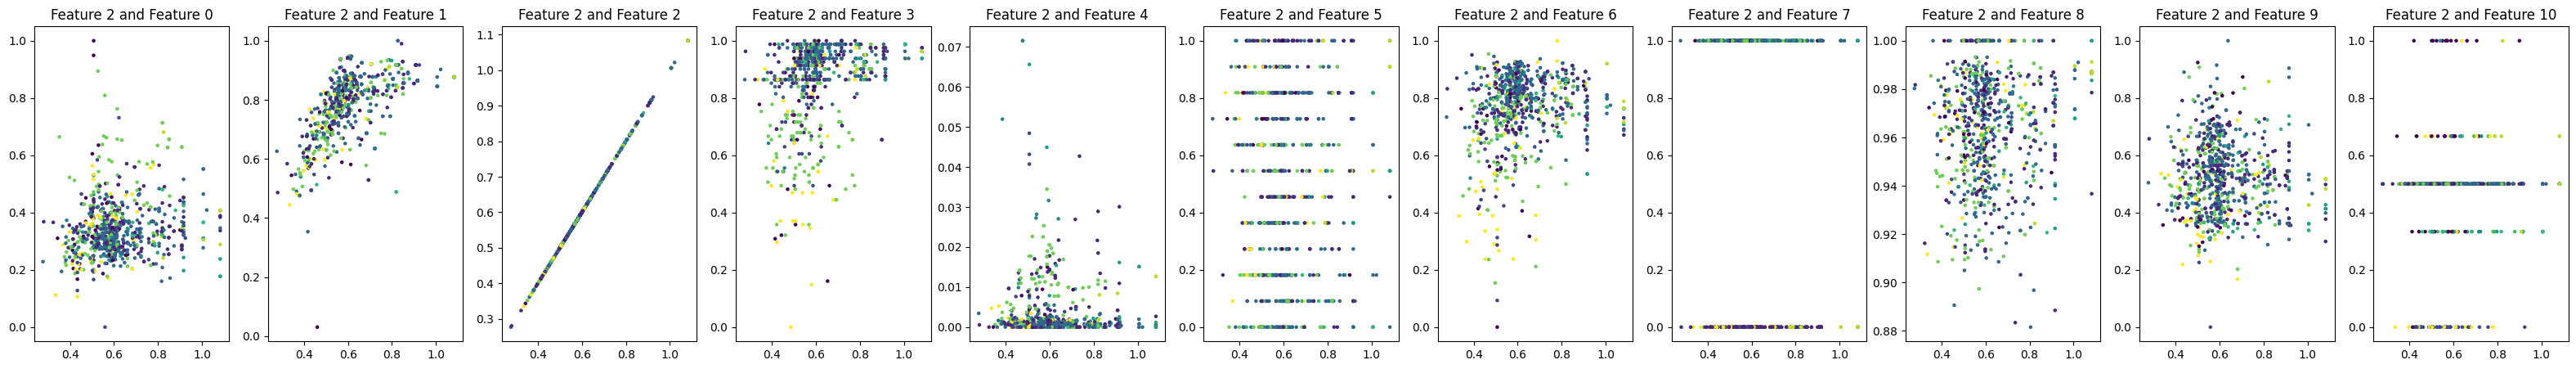

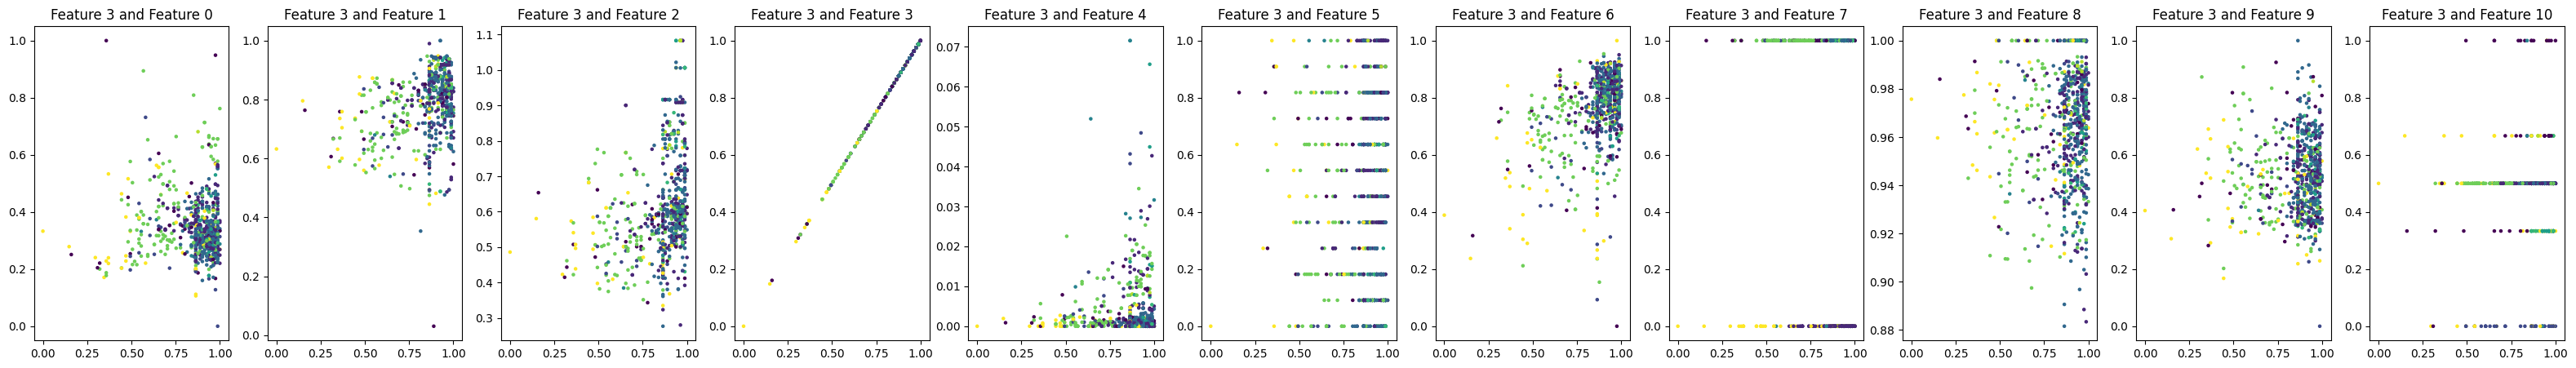

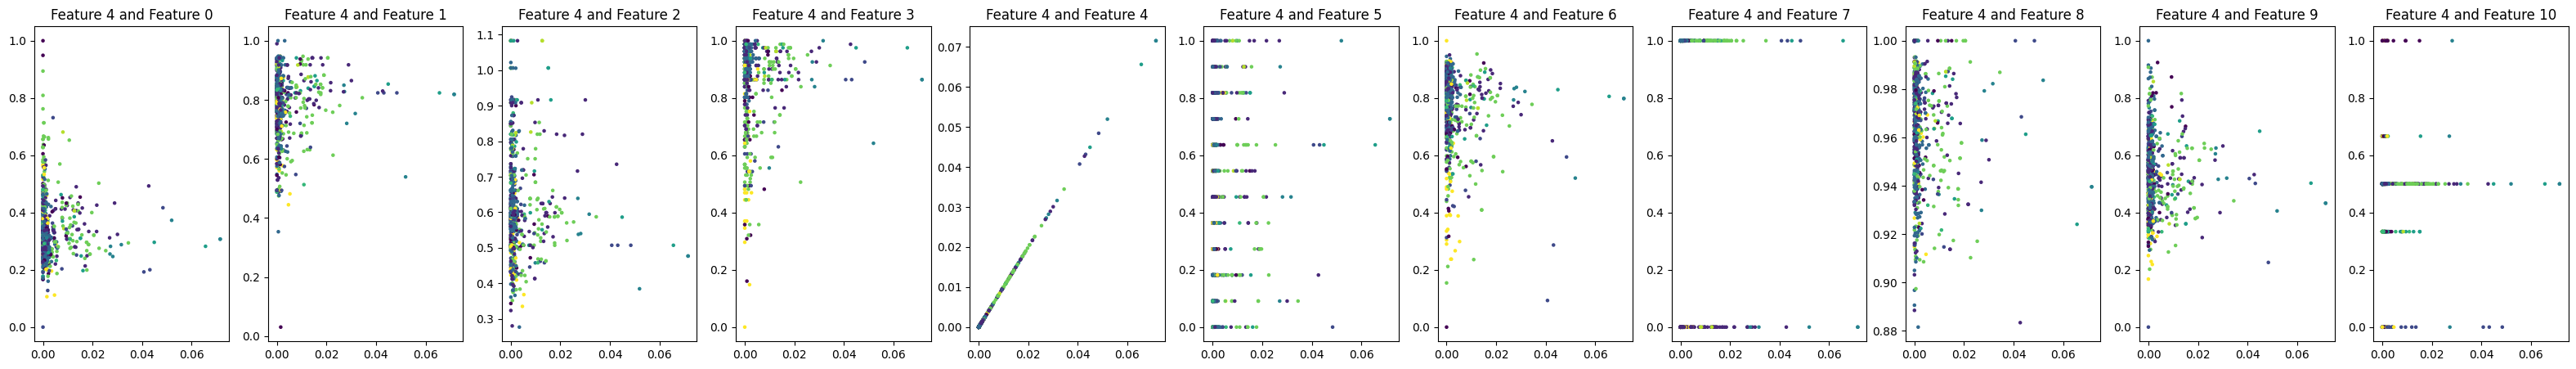

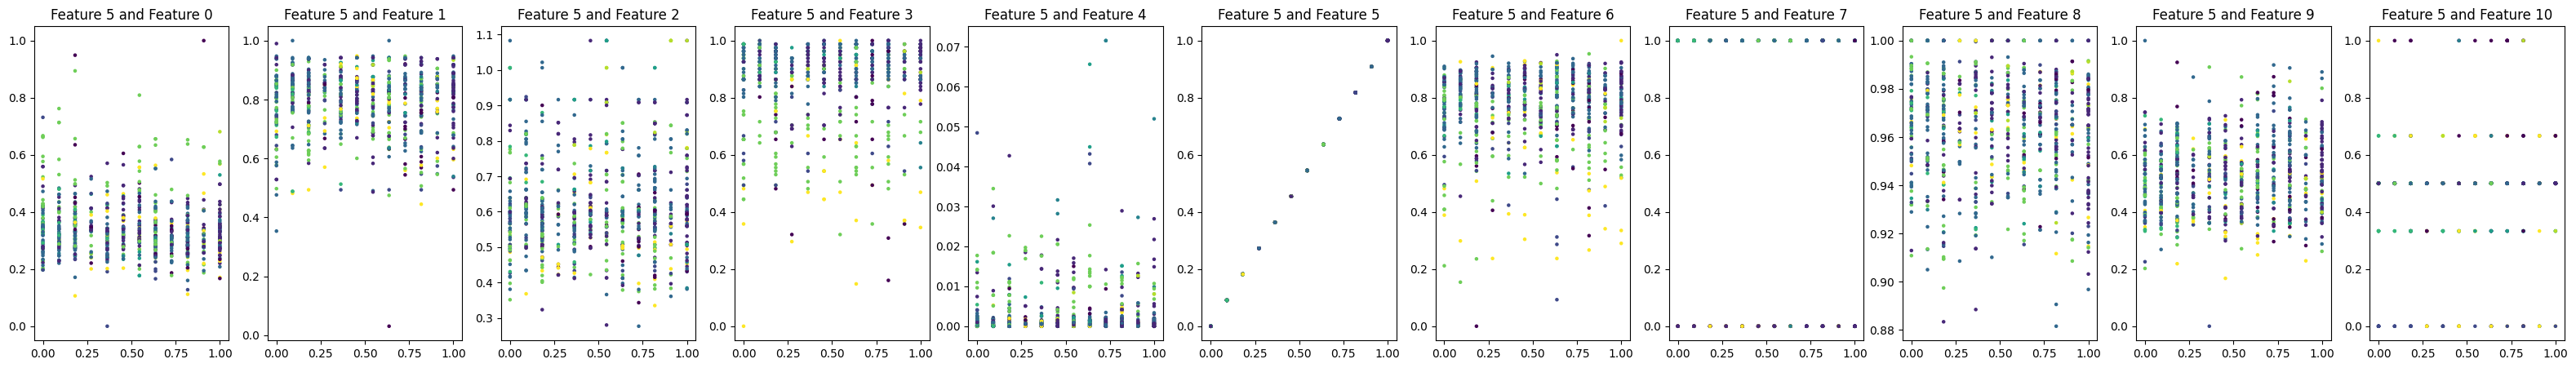

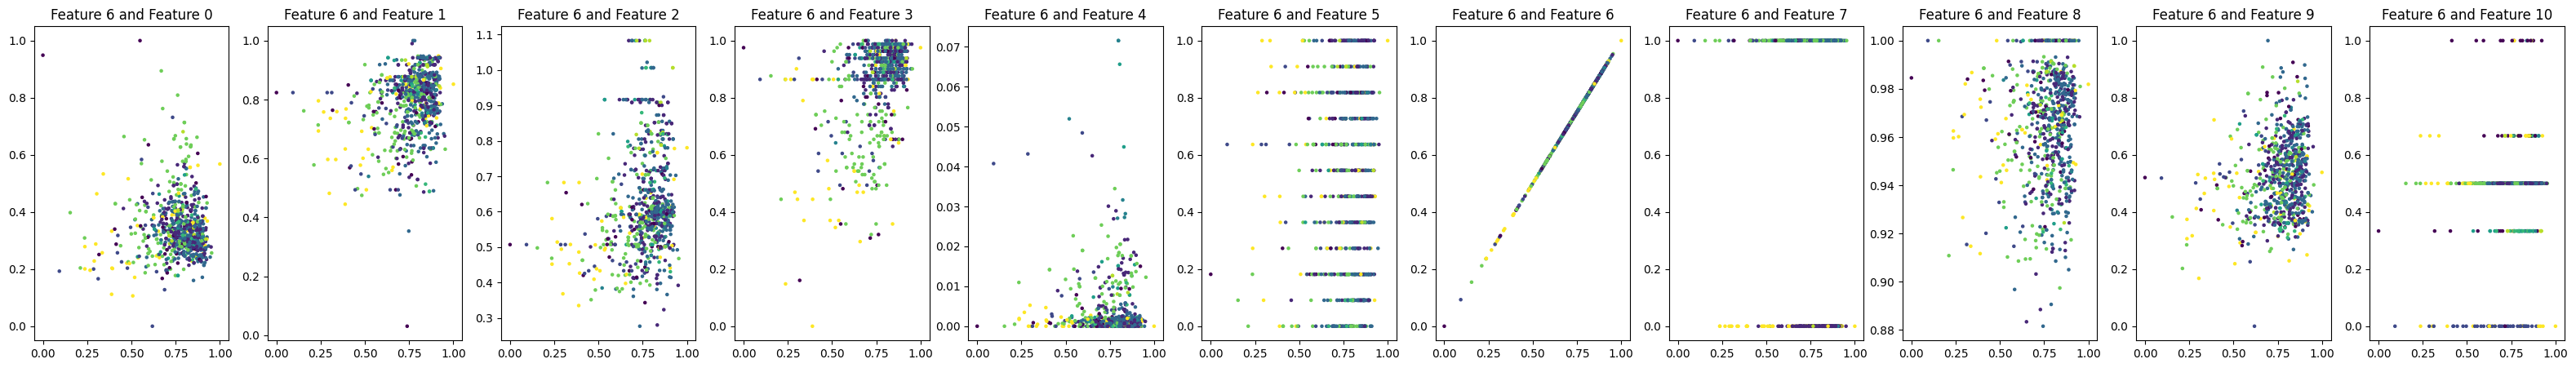

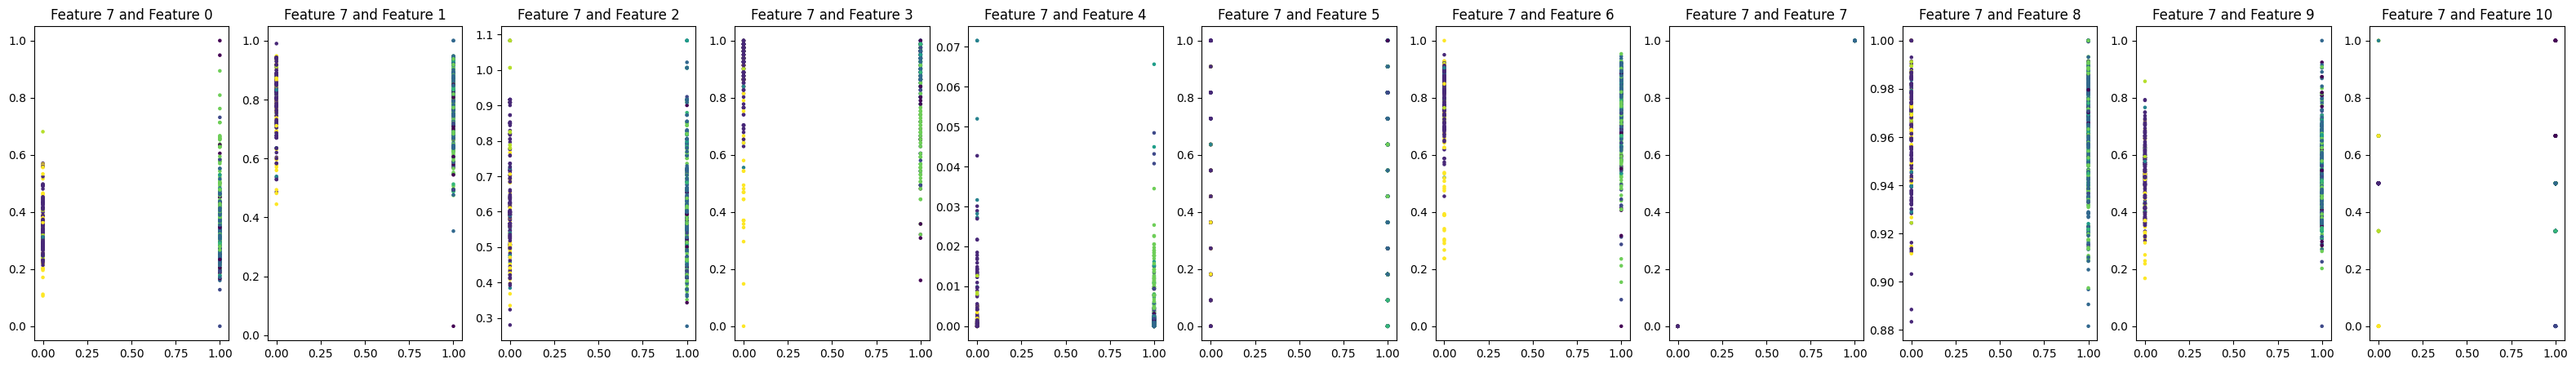

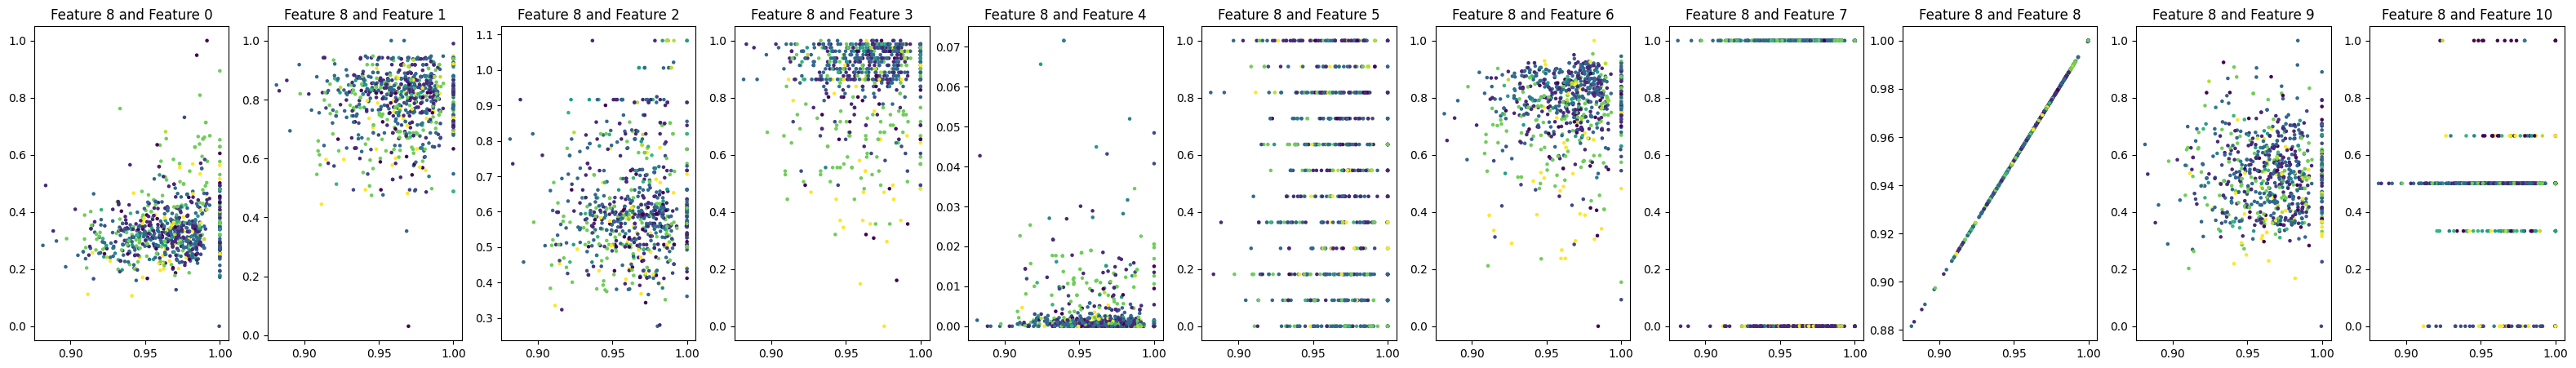

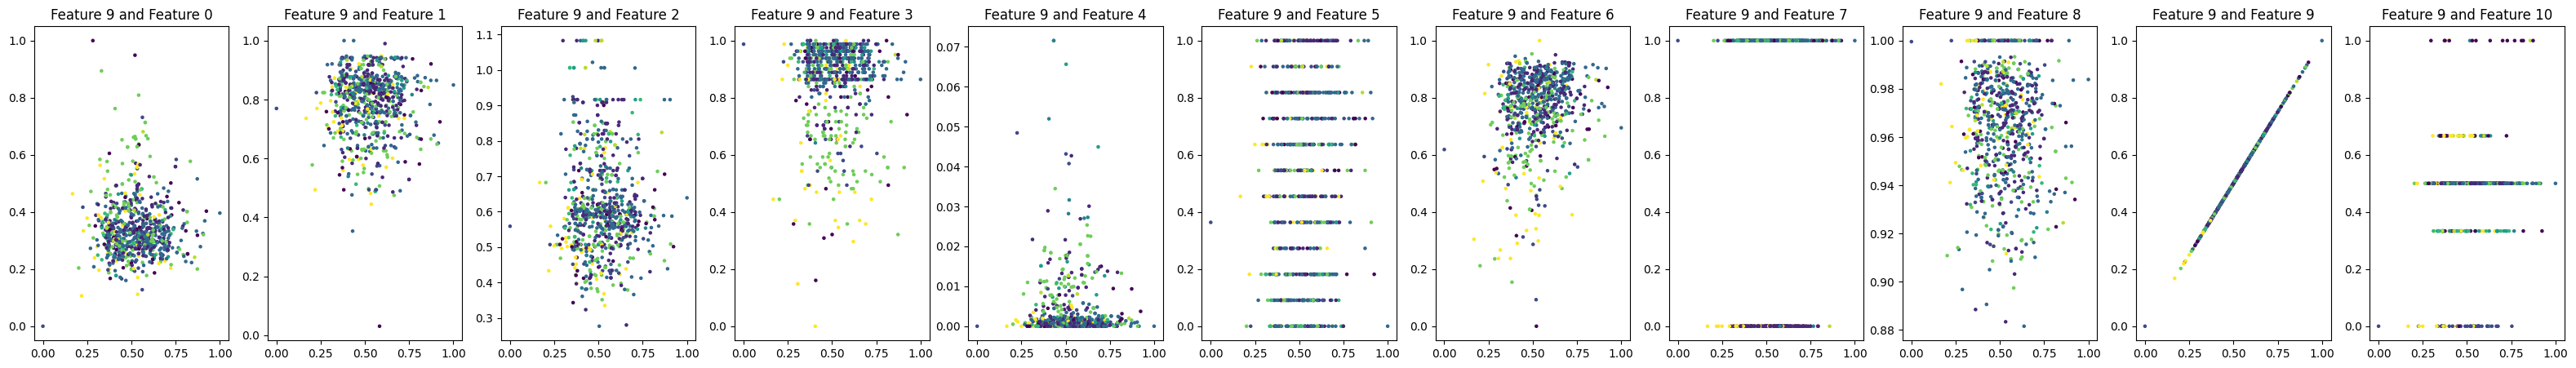

In [26]:
#Visualize feature distributions
gmModel = GaussianMixture(n_components = 10, random_state = 42)
gmModel.fit(X)
labels = gmModel.predict(X)

for i in range(gmModel.n_features_in_ - 1):
    fig, axs = plt.subplots(ncols = gmModel.n_features_in_, figsize = (40, 5))

    for j in range(gmModel.n_features_in_):
        axs[j].scatter(X.iloc[:, i], X.iloc[:, j], c = labels, s = 5)
        title = "Feature " + str(i) + " and Feature " + str(j)
        axs[j].set_title(title)

    plt.show()

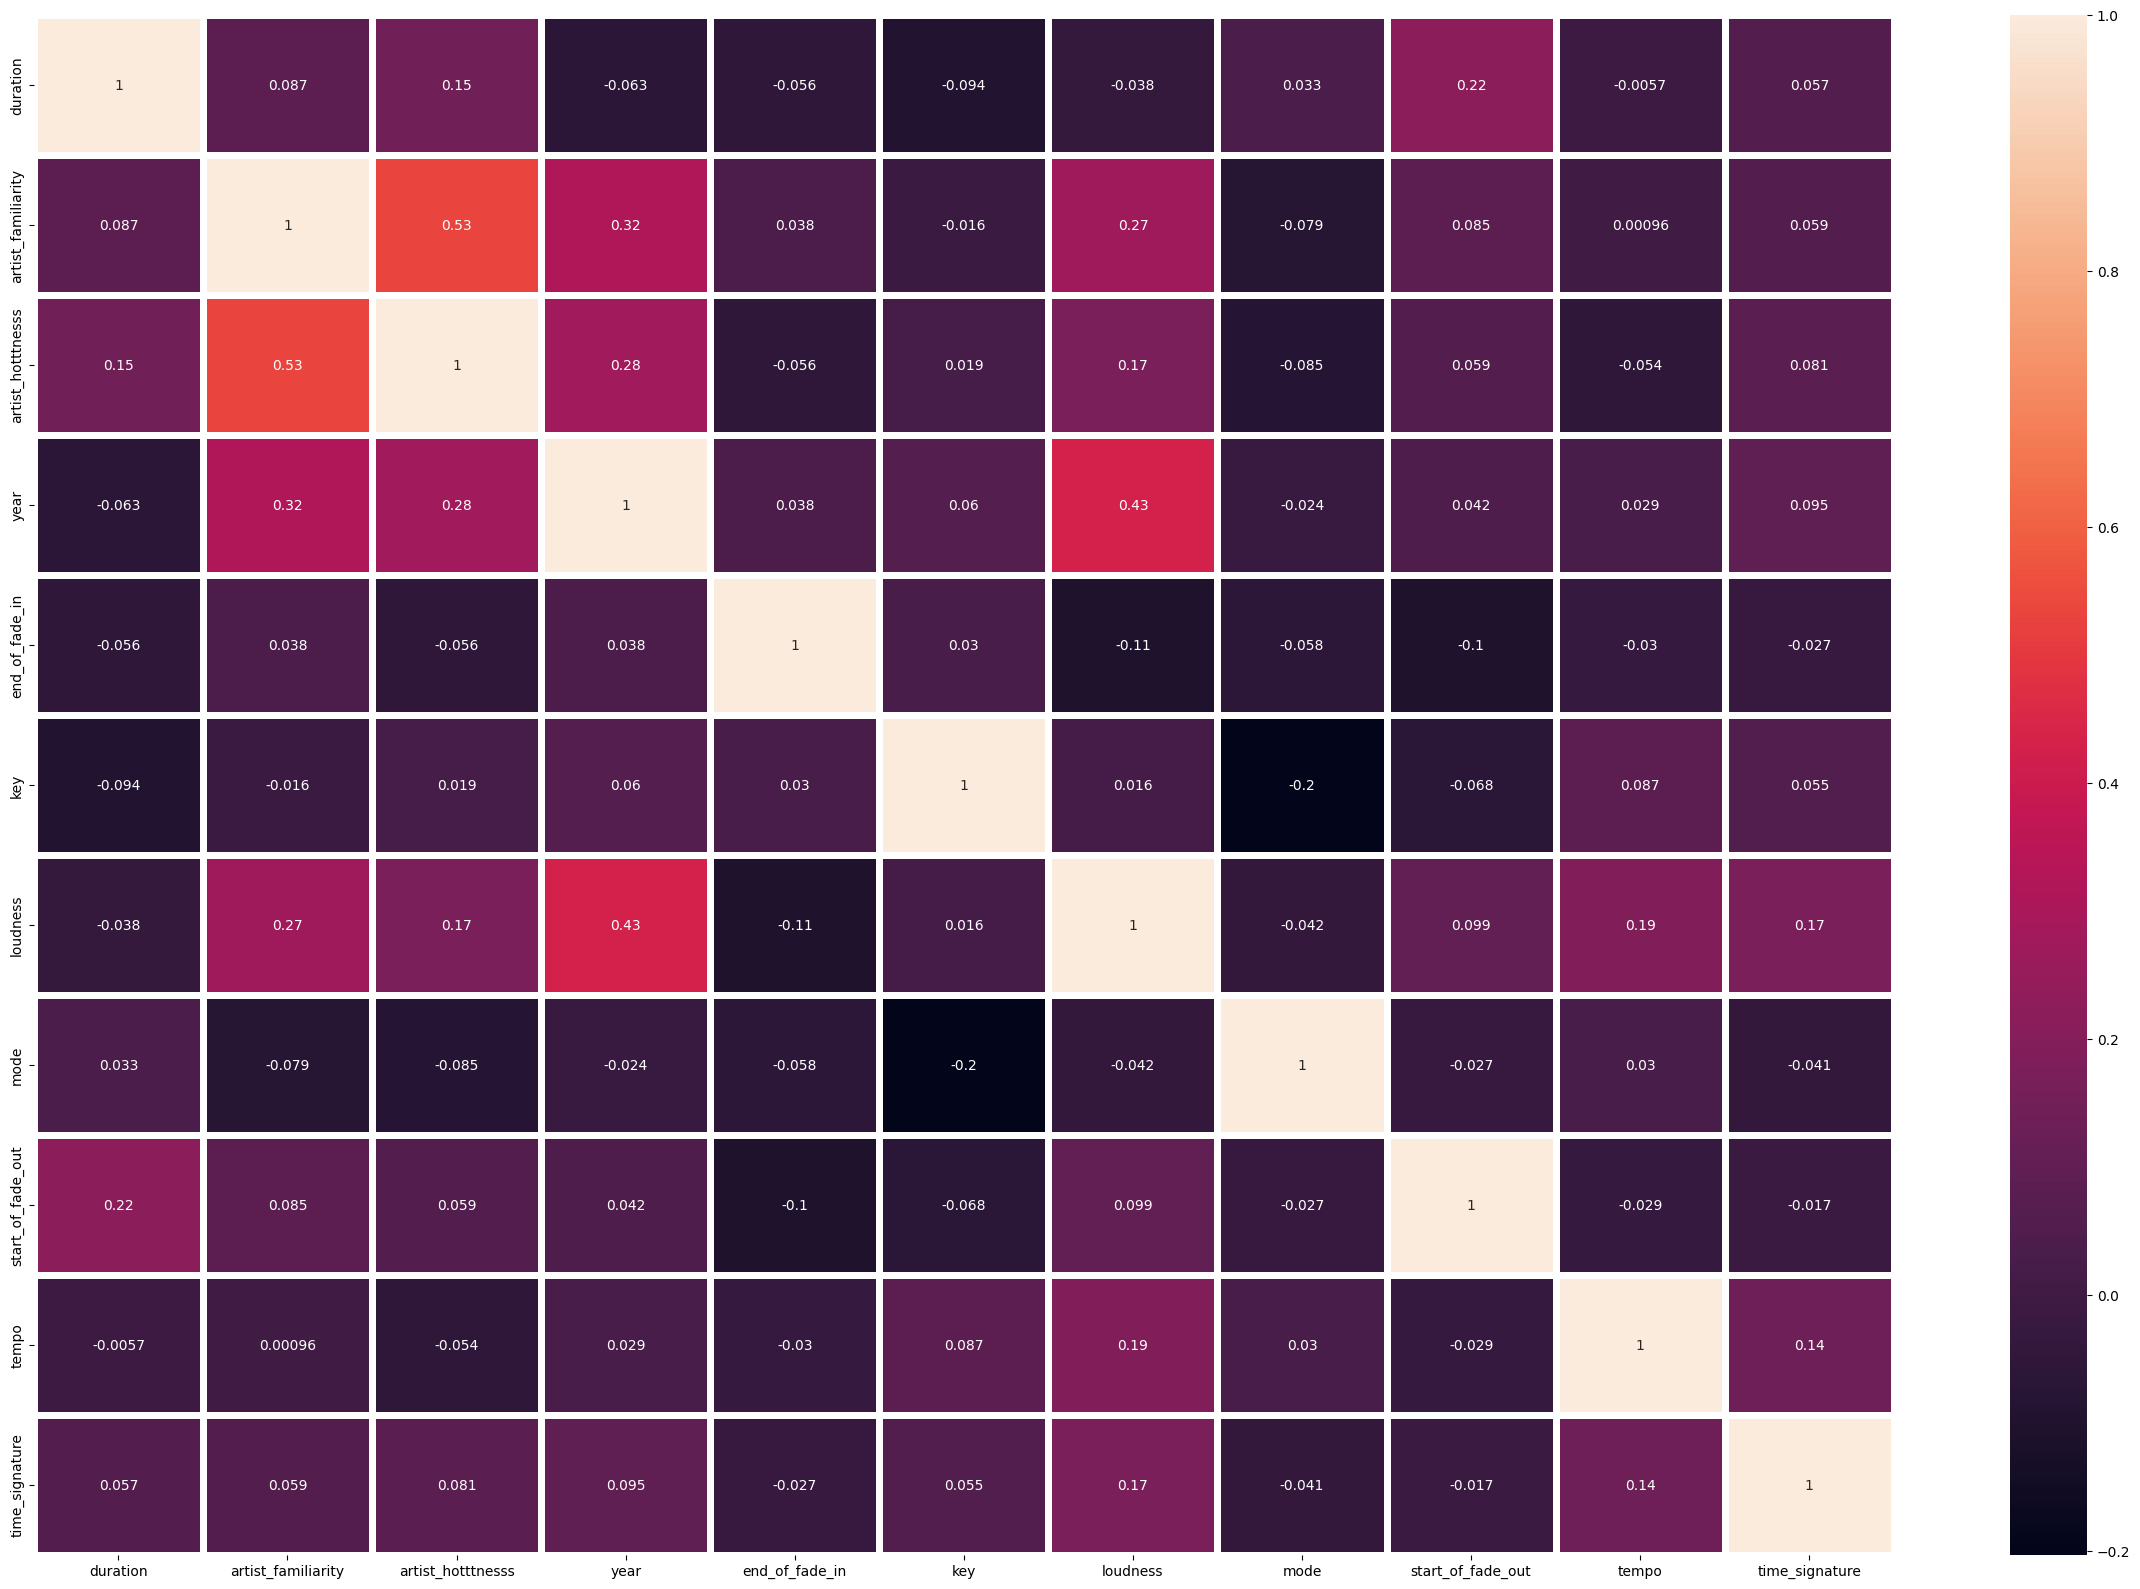

In [27]:
#Cleaned Data Correlation Matrix:
import seaborn as sn
import matplotlib.pyplot as plt

correlation_matrix = X.corr()

fig, ax = plt.subplots(figsize=(30, 20))
ax.set_ylim()

myheatmap = sn.heatmap(correlation_matrix, annot = True, linewidths=5, ax=ax)

plt.show()

Text(0.5, 0, 'n_components')

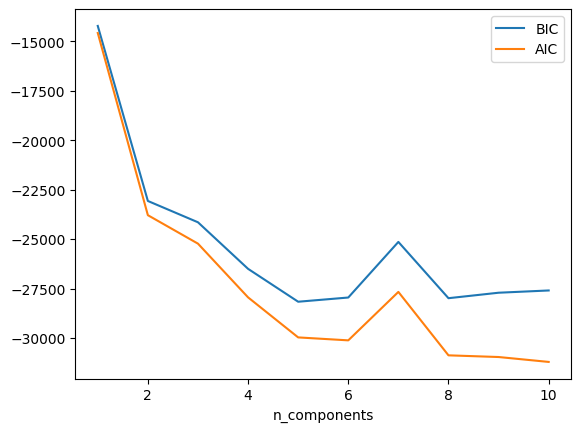

In [28]:
#Visualize BIC and AIC curves
temp_n_components = [x for x in range(1, 11)]
models = [GaussianMixture(n, covariance_type = 'full', random_state = 42).fit(X) for n in temp_n_components]

plt.plot(temp_n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(temp_n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

For n_clusters = 2 The average silhouette_score is : 0.4796992963951349
For n_clusters = 3 The average silhouette_score is : 0.22747895838246024
For n_clusters = 4 The average silhouette_score is : 0.18499093098656427
For n_clusters = 5 The average silhouette_score is : 0.07647263608106465
For n_clusters = 6 The average silhouette_score is : 0.03460302416095388
For n_clusters = 7 The average silhouette_score is : 0.11069912106398595
For n_clusters = 8 The average silhouette_score is : 0.007842227014823705
For n_clusters = 9 The average silhouette_score is : -0.03422064433209373
For n_clusters = 10 The average silhouette_score is : -0.04759866400681542
For n_clusters = 11 The average silhouette_score is : -0.05088165703680529


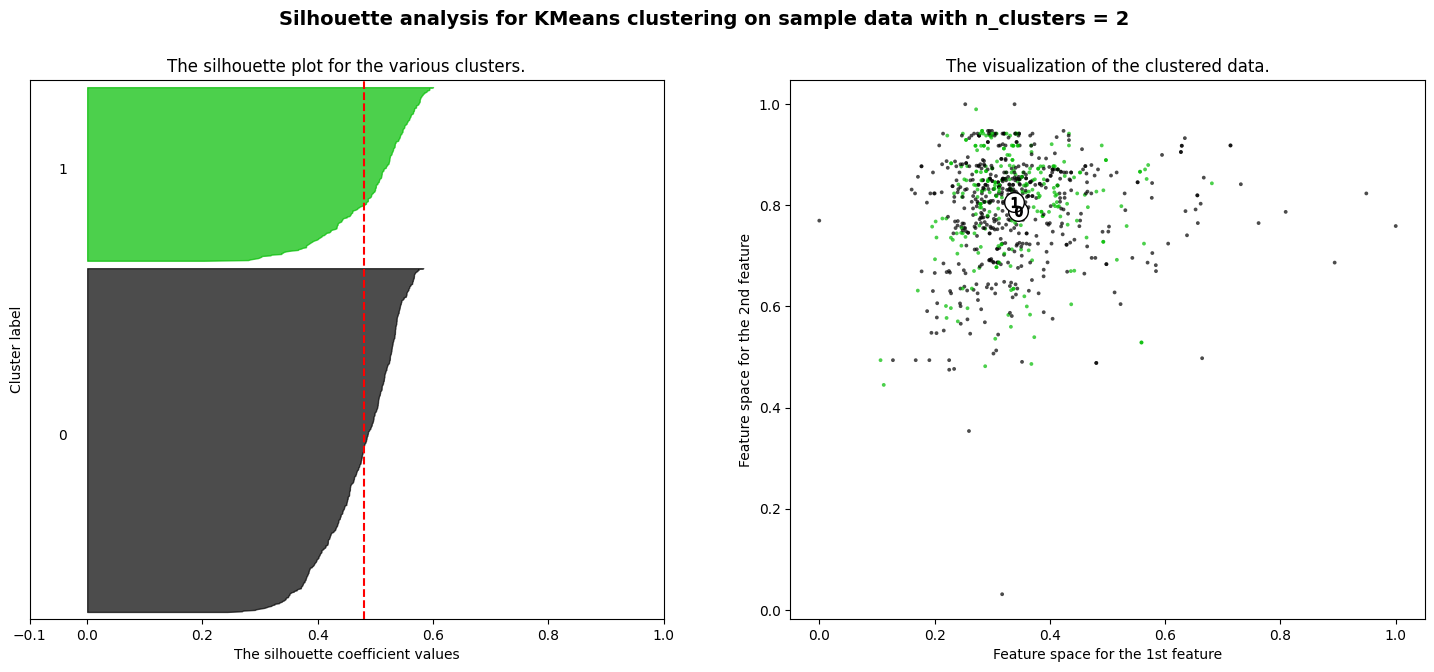

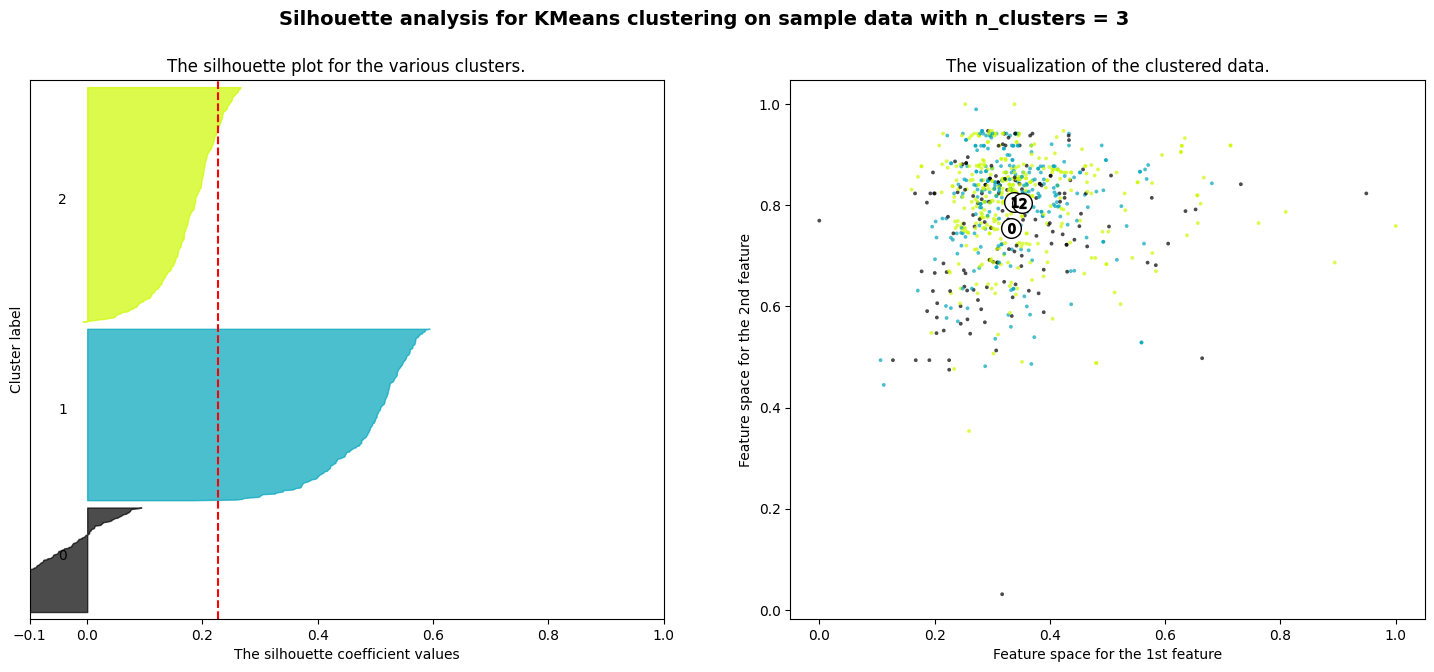

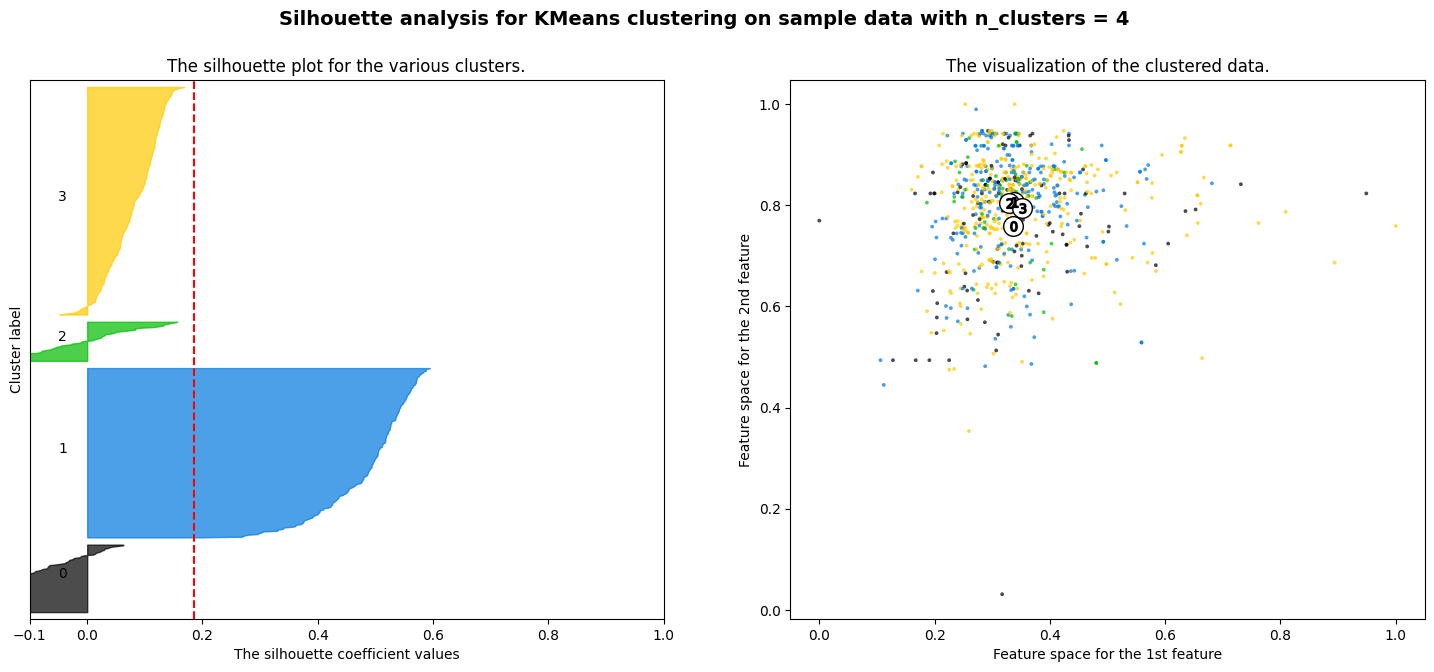

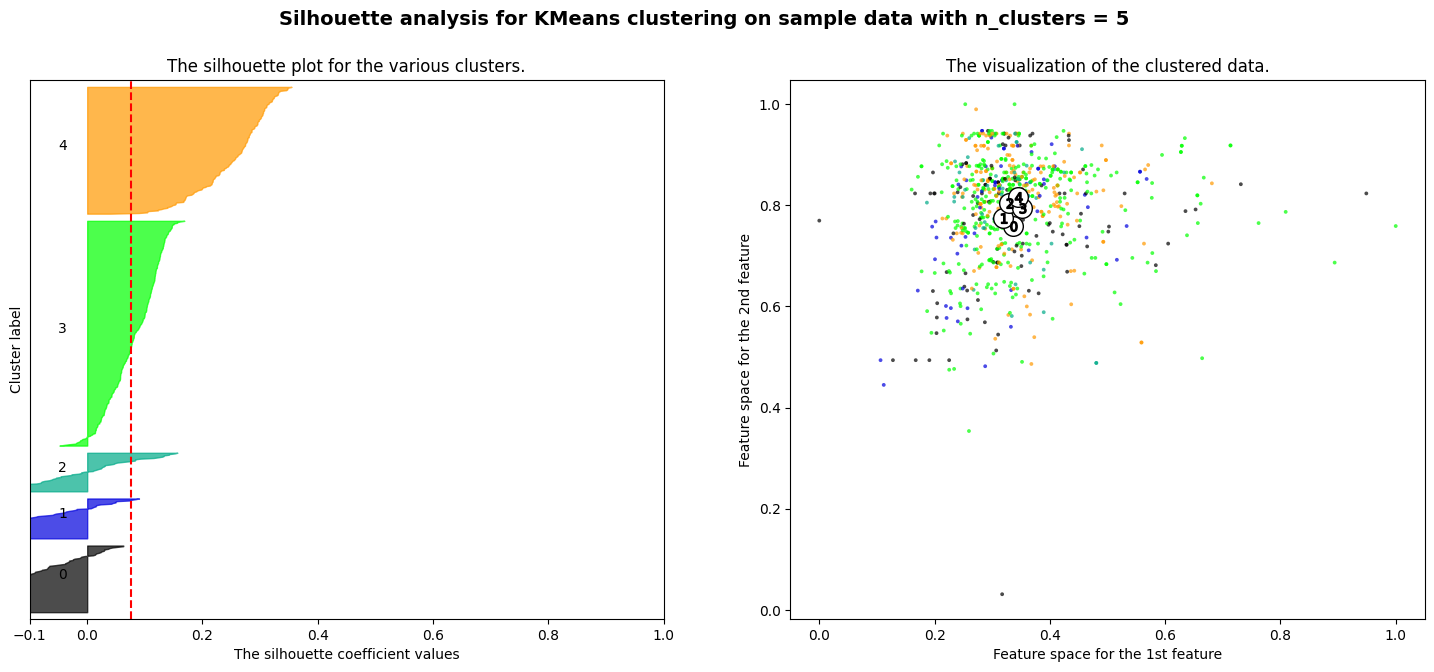

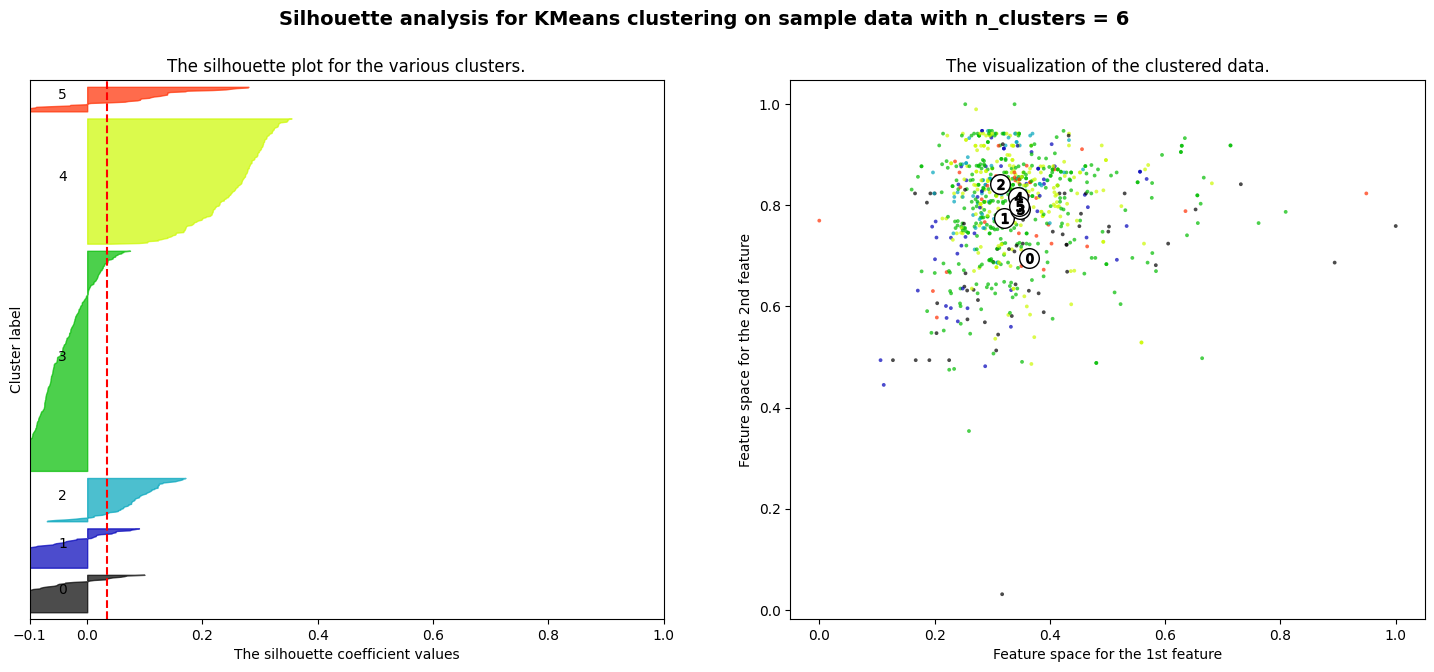

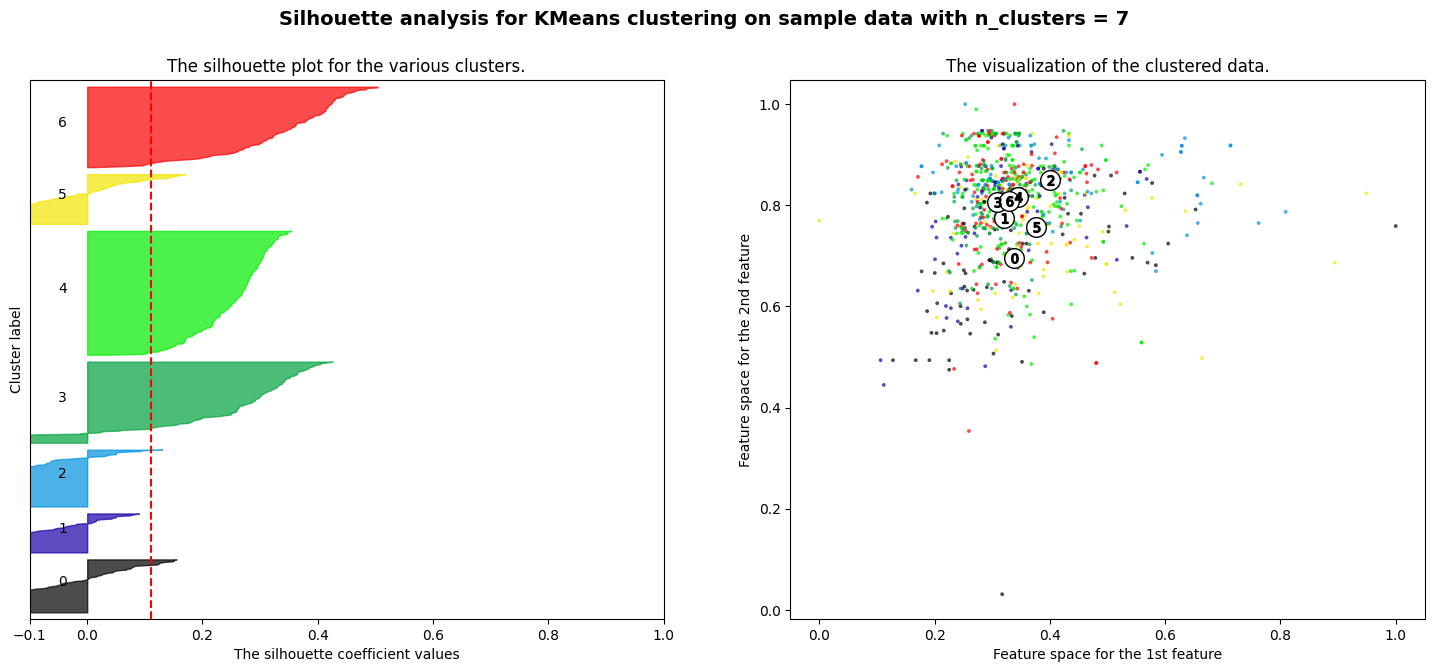

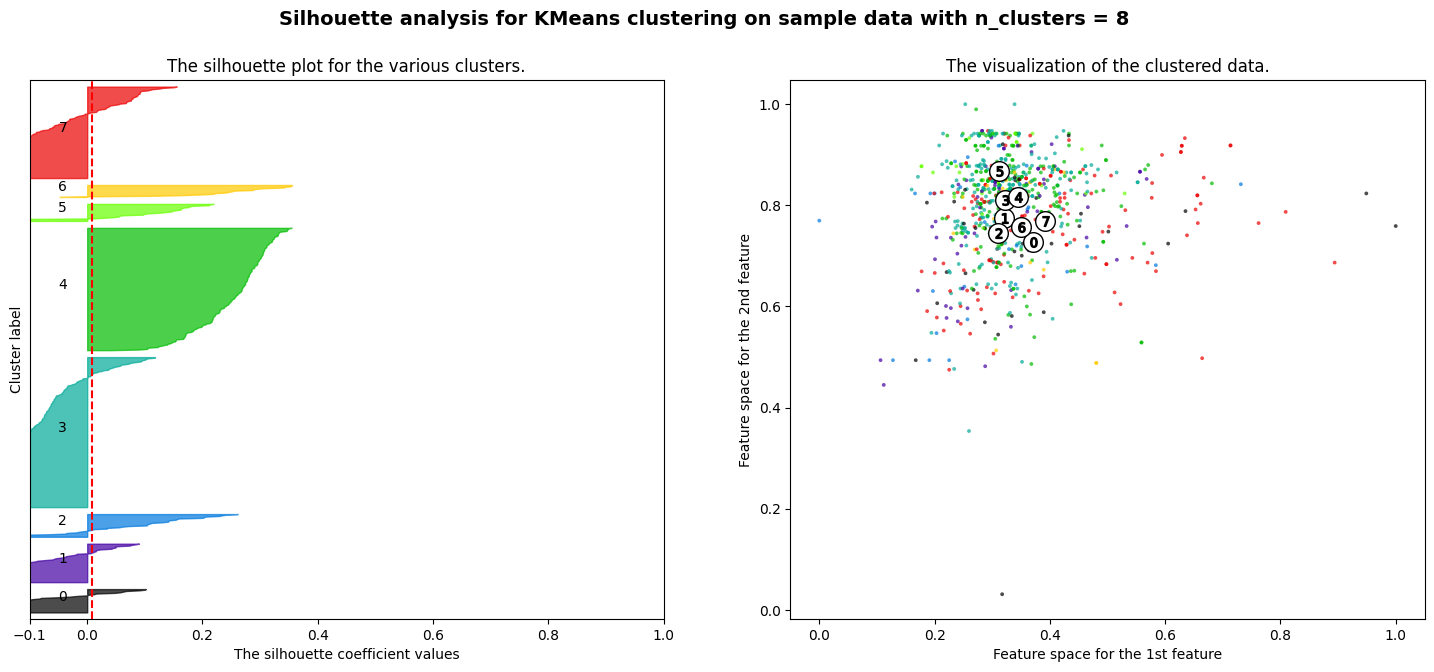

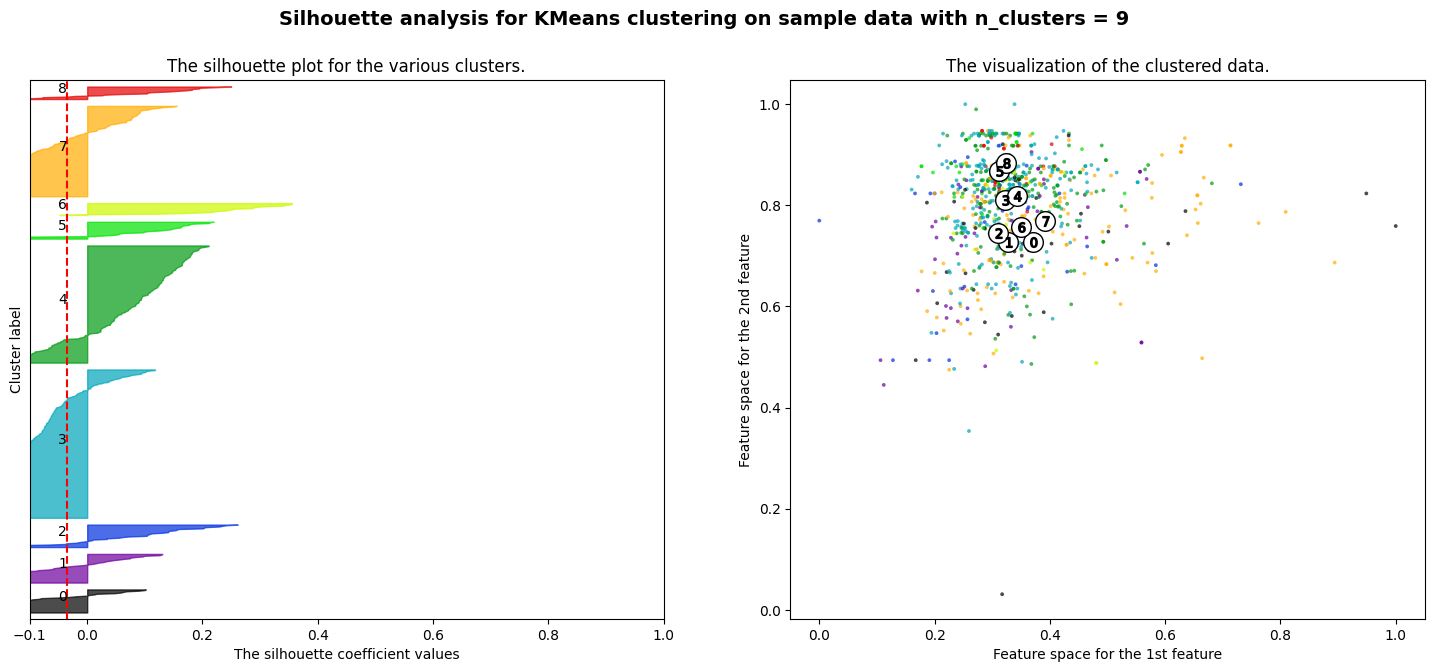

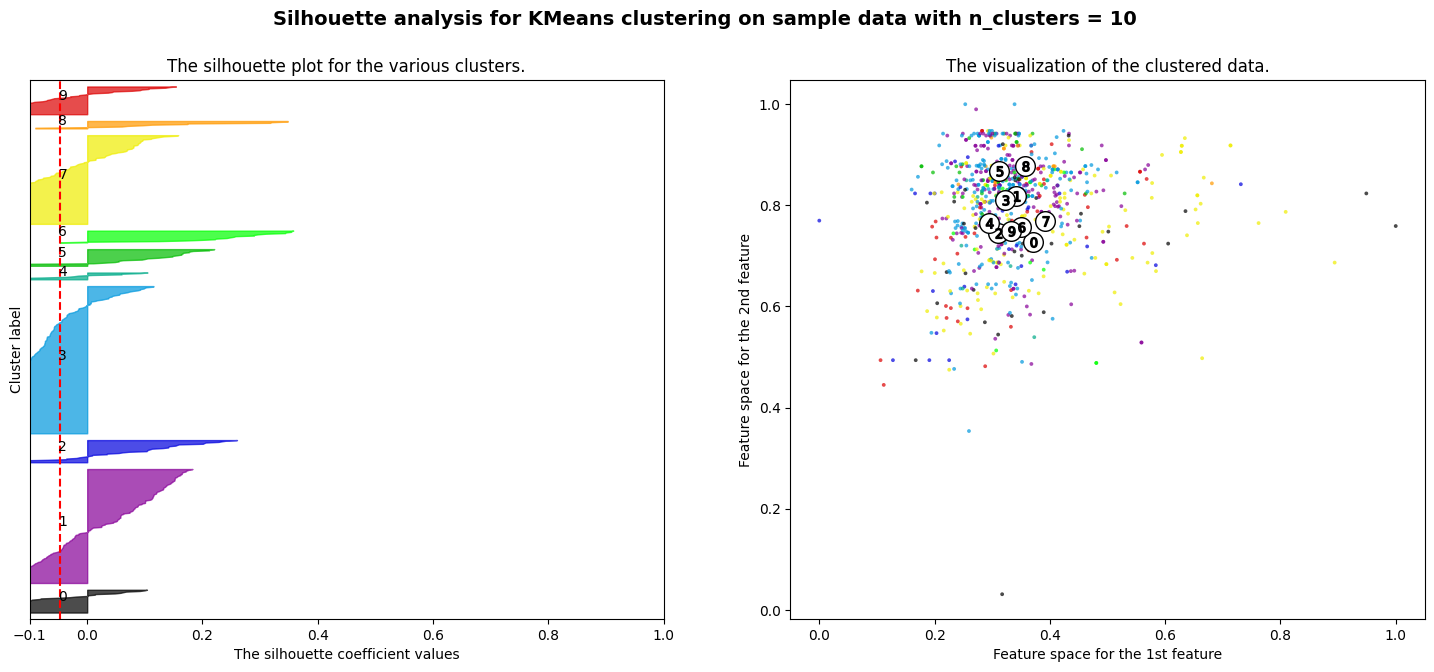

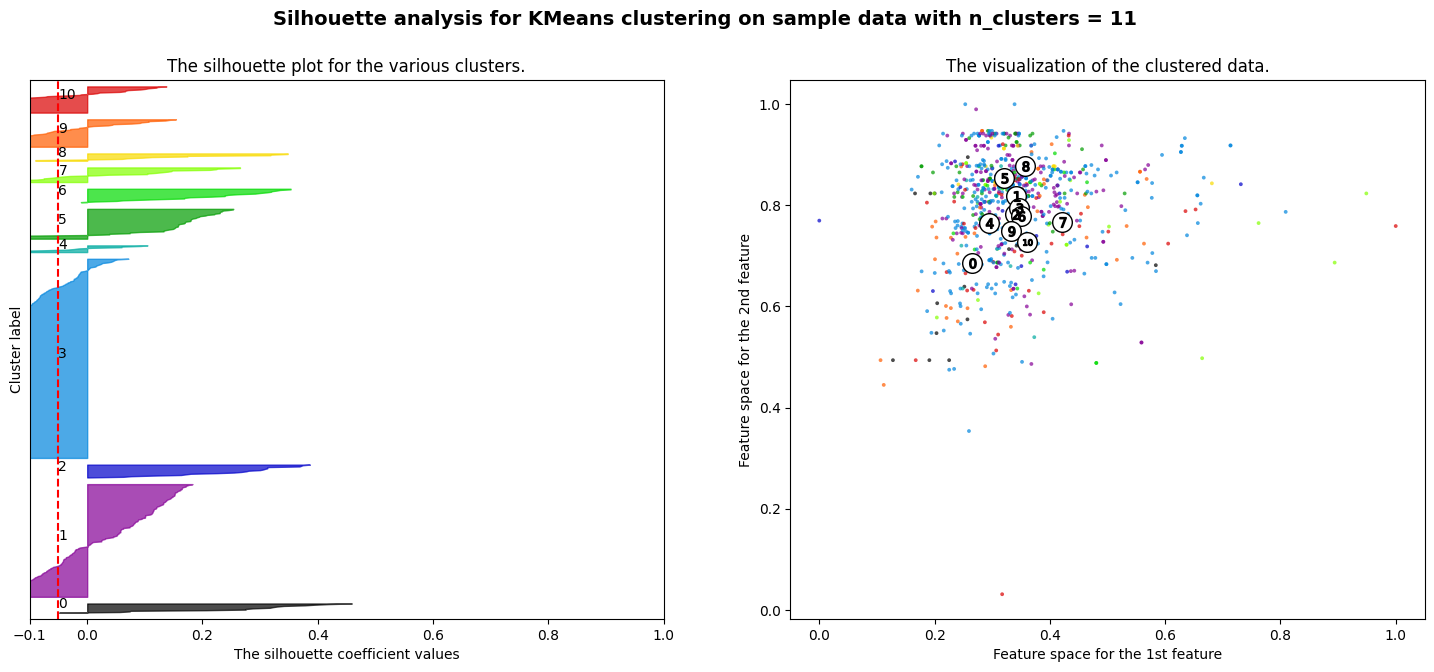

In [29]:
#This code block is a modified example from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]                                 #range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    gmModel = GaussianMixture(n_components = n_clusters, random_state = 42)                     # clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = gmModel.fit_predict(X)                                                     # cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = gmModel.means_                                        # centers = clusterer.cluster_centers_

    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()